In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

## Generate real data

In [2]:
! wc -l /home/daniil/Desktop/bioinformatics_group/june/DATA_TRIADS/TRIADS/RNA_WINDOW_100_DNA_WINDOW_2000/*[C2].bed | awk -F' ' '{print $2"\t"$1}' > real_data.tsv

In [3]:
def rename_triad_entity(st):
    s = st.split('.')
    rdexp = '_'.join(s[1].split('_')[:2])
    return '.'.join([s[0],rdexp, s[3]])

real = pd.read_csv("real_data.tsv", sep='\t', header=None).rename(columns={0:"fname", 1:"triad_count"}).iloc[:-1, :]
real["fname"] = real["fname"].apply(lambda x: x.split('/')[-1])
real["fname"] = real["fname"].apply(lambda x: rename_triad_entity(x))
real[real.fname.str.startswith("KH")]

,fname,triad_count
25,KHSRP.redc_K562.eCLIP,173


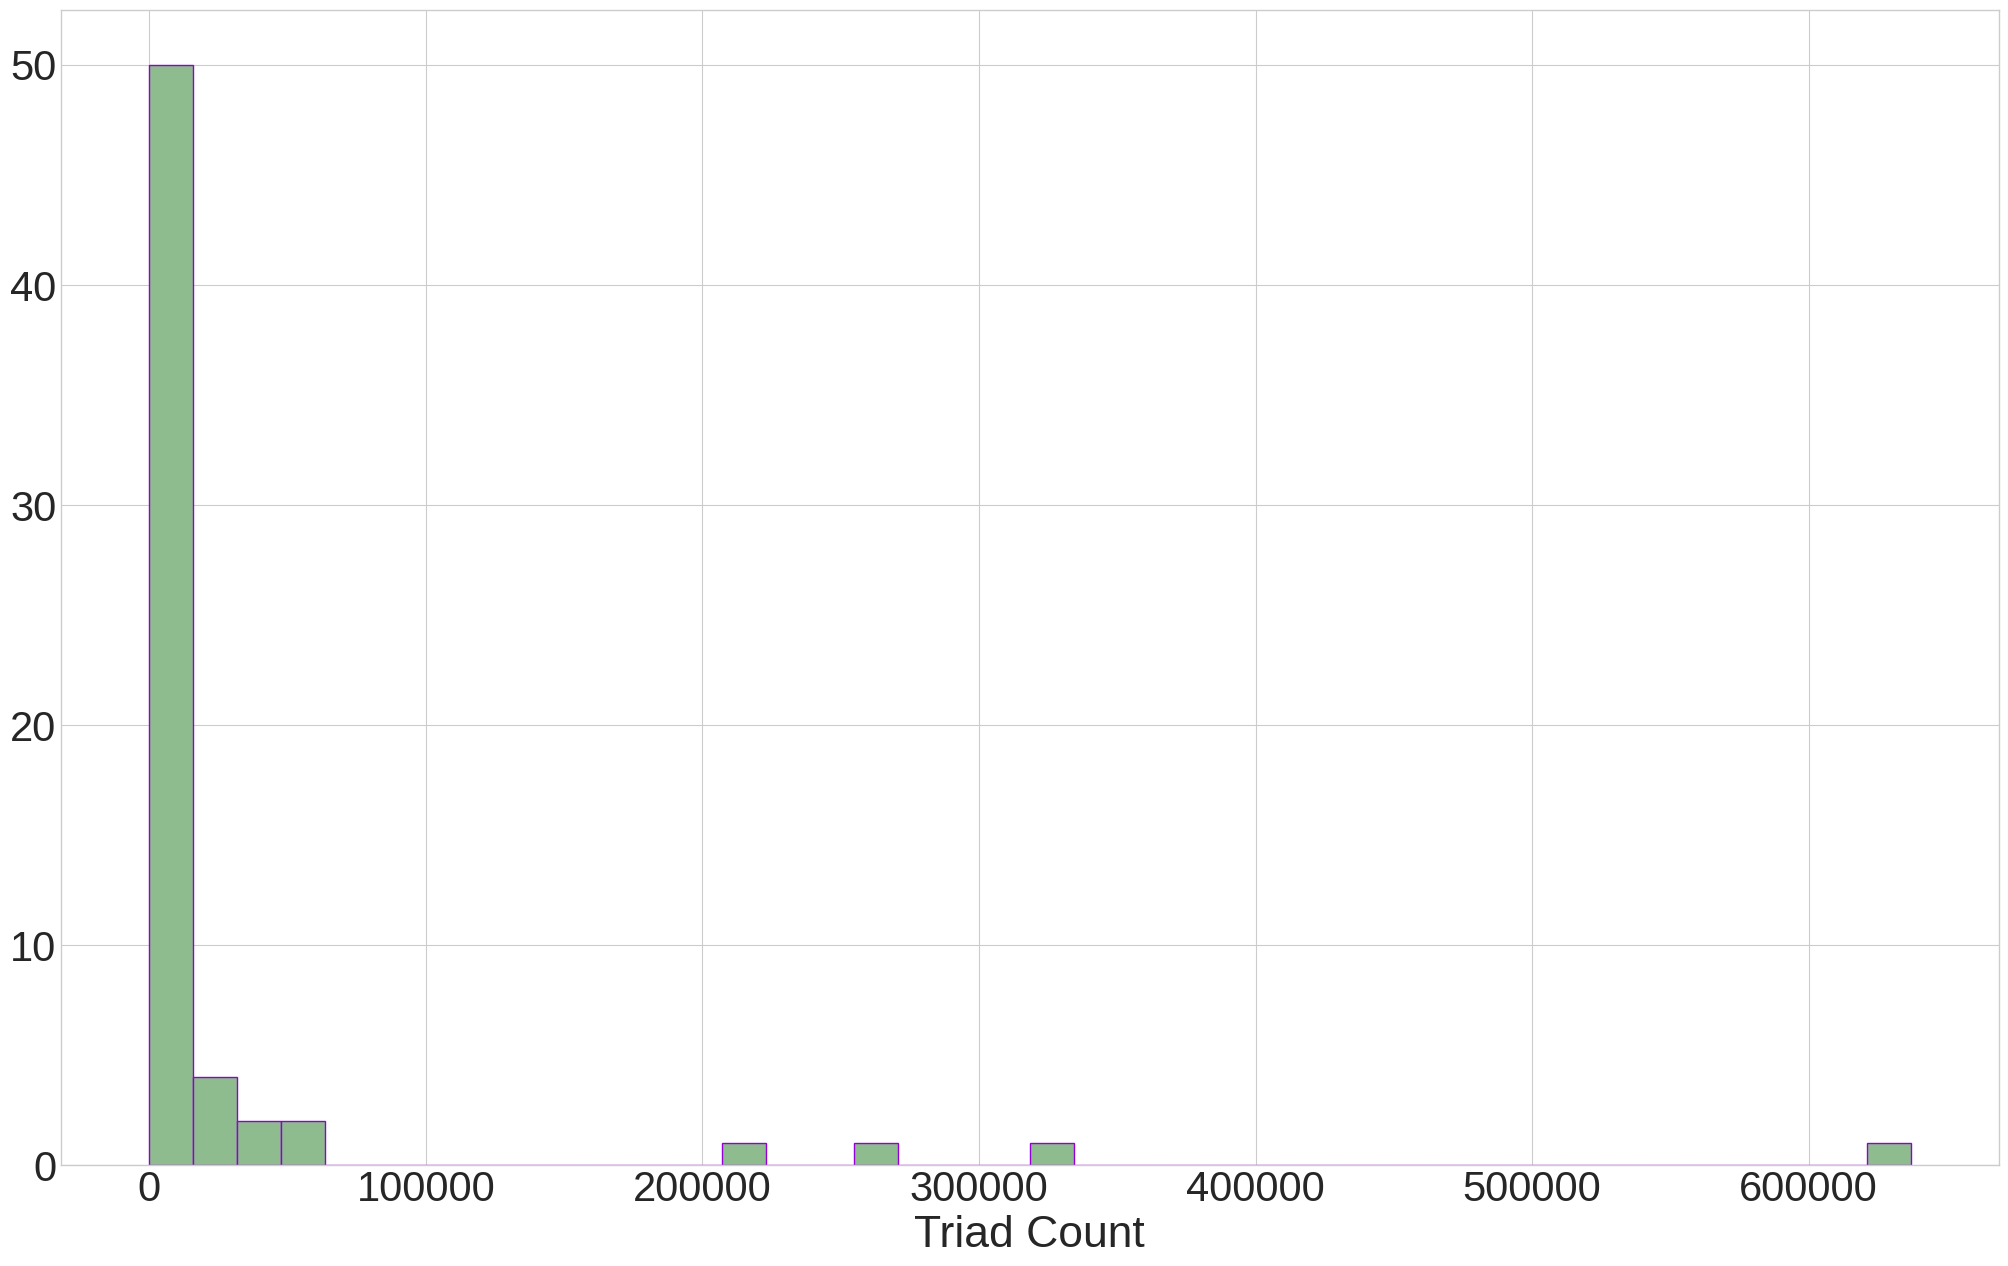

In [4]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(25,15))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("Triad Count", fontsize=32)
#kde = gaussian_kde(real["triad_count"])
#xx = np.linspace(0, 16000, 10_000)

plt.hist(real["triad_count"], color = "darkseagreen", ec="darkviolet", bins=40)
plt.show()

## Read in simulation data from Babylon

In [5]:
ChromHMM_states = ["Enhancer", "HetChrom_CNV", "Insulator", "PRC_Repressed", "Promoter",
                  "Transcribed"]
SPIN_states = ["A_compartment", "B_compartment", "Lamina", "Near_Lm", "Speckle", "Lamina_Like"]

In [6]:
dt_counts = {}
dt_chromHMM = {}
dt_spin = {}
with open("sim_annot_1.tsv", 'r') as inp:
    for line in inp:
        step_res = list(map(lambda x: x.strip(), line.split('\t')))
        ind = step_res[0]
        tri_count = step_res[1].split(' ')
        triad, tri_count = tri_count[1].split('/')[-1], int(tri_count[0])
        
        dt_counts[(ind, triad)] = tri_count
        dt_chromHMM[(ind, triad)] = {state: 1 for state in ChromHMM_states}
        dt_spin[(ind, triad)] = {state: 1 for state in SPIN_states}
        
        states_cnts = list(filter(lambda x: len(x) > 1, map(lambda x: x.split(' '), step_res[2:])))
        for val, state in states_cnts:
            if state in ChromHMM_states:
                dt_chromHMM[(ind, triad)][state] = int(val)
            elif state in SPIN_states:
                try:
                    dt_spin[(ind, triad)][state] = int(val)
                except ValueError:
                    dt_spin[(ind, triad)][state] = val
    last_ind = int(ind)

In [7]:
def rename_triad_entity(st):
    s = st.split('.')
    rdexp = '_'.join(s[1].split('_')[0::2])
    return '.'.join([s[0],rdexp, s[3]])

simulation_table = pd.DataFrame([list(map(lambda x: x[0], dt_counts.keys())),
              list(map(lambda x: x[1], dt_counts.keys())),
              list(dt_counts.values())]).transpose().rename(columns={0:"itr", 1:"Prot", 2:"triad_count"})
simulation_table["Prot"] = simulation_table.Prot.apply(lambda x: rename_triad_entity(x)).astype(str)
simulation_table["triad_count"] = simulation_table["triad_count"].astype(int)
simulation_table["itr"] = simulation_table["itr"].astype(int)
simulation_table_pivoted = simulation_table.pivot(index="Prot", columns="itr", values="triad_count")

In [8]:
x = pd.DataFrame([list(map(lambda x: x[0], dt_chromHMM.keys())),
              list(map(lambda x: x[1], dt_chromHMM.keys())),
              list(dt_chromHMM.values())]).transpose()
chromHMM_df = pd.concat([x.drop([2], axis=1), x[2].apply(pd.Series)], axis=1).rename(columns={0:"itr", 1:"Prot"})
chromHMM_df["Prot"] = chromHMM_df.Prot.apply(lambda x: rename_triad_entity(x)).astype(str)
chromHMM_df["itr"] = chromHMM_df["itr"].astype(int)
chromHMM_df.iloc[:, 2:] = chromHMM_df.iloc[:, 2:].astype(int)

In [9]:
x = pd.DataFrame([list(map(lambda x: x[0], dt_spin.keys())),
              list(map(lambda x: x[1], dt_spin.keys())),
              list(dt_spin.values())]).transpose()
spin_df = pd.concat([x.drop([2], axis=1), x[2].apply(pd.Series)], axis=1).rename(columns={0:"itr", 1:"Prot"})
spin_df["Prot"] = spin_df.Prot.apply(lambda x: rename_triad_entity(x)).astype(str)
spin_df["Org"] = spin_df["Prot"].apply(lambda x: x.split('.')[1].split('_')[1])
spin_df = spin_df[spin_df["Org"] != "mESC"]
spin_df["itr"] = spin_df["itr"].astype(int)
spin_df.iloc[:, 2:-1] = spin_df.iloc[:, 2:-1].astype(int)
spin_df = spin_df.iloc[:, :-1]

## Read in simulation data from Makarich

In [10]:
from tqdm.auto import tqdm

In [11]:
dt_counts_mak = {}
dt_chromHMM_mak = {}
dt_spin_mak = {}

for i, file in tqdm(enumerate(glob.glob("makarich_sims/sim*tsv") + ["sim_annot_2.tsv", "sim_annot_3.tsv"])):
    start_ind = (last_ind + 1)
    with open(file, 'r') as inp:
        for line in inp:
            step_res = list(map(lambda x: x.strip(), line.split('\t')))
            
            ind = int(step_res[0]) + start_ind
            tri_count = step_res[1].split(' ')
            triad, tri_count = tri_count[1].split('/')[-1], int(tri_count[0])
            dt_counts_mak[(ind, triad)] = tri_count
            dt_chromHMM_mak[(ind, triad)] = {state: 1 for state in ChromHMM_states}
            dt_spin_mak[(ind, triad)] = {state: 1 for state in SPIN_states}
            states_cnts = list(filter(lambda x: len(x) > 1, map(lambda x: x.split(' '), step_res[2:])))
            for val, state in states_cnts:
                if state in ChromHMM_states:
                    dt_chromHMM_mak[(ind, triad)][state] = int(val)
                elif state in SPIN_states:
                    try:
                        dt_spin_mak[(ind, triad)][state] = int(val)
                    except ValueError:
                        dt_spin_mak[(ind, triad)][state] = val
        last_ind = int(ind)

0it [00:00, ?it/s]

In [12]:
mak_counts = pd.DataFrame([list(map(lambda mak_counts: mak_counts[0], dt_counts_mak.keys())),
              list(map(lambda mak_counts: mak_counts[1], dt_counts_mak.keys())),
              list(dt_counts_mak.values())]).transpose().rename(columns={0:"itr", 1:"Prot", 2:"triad_count"})
mak_counts["Prot"] = mak_counts.Prot.apply(lambda mak_counts: rename_triad_entity(mak_counts)).astype(str)
mak_counts["triad_count"] = mak_counts["triad_count"].astype(int)
mak_counts["itr"] = mak_counts["itr"].astype(int)

In [13]:
x = pd.DataFrame([list(map(lambda x: x[0], dt_chromHMM_mak.keys())),
              list(map(lambda x: x[1], dt_chromHMM_mak.keys())),
              list(dt_chromHMM_mak.values())]).transpose()
chromHMM_df_mak = pd.concat([x.drop([2], axis=1), x[2].apply(pd.Series)], axis=1).rename(columns={0:"itr", 1:"Prot"})
chromHMM_df_mak["Prot"] = chromHMM_df_mak.Prot.apply(lambda x: rename_triad_entity(x)).astype(str)
chromHMM_df_mak["itr"] = chromHMM_df_mak["itr"].astype(int)
chromHMM_df_mak.iloc[:, 2:] = chromHMM_df_mak.iloc[:, 2:].astype(int)

In [14]:
x = pd.DataFrame([list(map(lambda x: x[0], dt_spin_mak.keys())),
              list(map(lambda x: x[1], dt_spin_mak.keys())),
              list(dt_spin_mak.values())]).transpose()
spin_df_mak = pd.concat([x.drop([2], axis=1), x[2].apply(pd.Series)], axis=1).rename(columns={0:"itr", 1:"Prot"})
spin_df_mak["Prot"] = spin_df_mak.Prot.apply(lambda x: rename_triad_entity(x)).astype(str)
spin_df_mak["Org"] = spin_df_mak["Prot"].apply(lambda x: x.split('.')[1].split('_')[1])
spin_df_mak = spin_df_mak[spin_df_mak["Org"] != "mESC"]
spin_df_mak["itr"] = spin_df_mak["itr"].astype(int)
spin_df_mak.iloc[:, 2:-1] = spin_df_mak.iloc[:, 2:-1].astype(int)
spin_df_mak = spin_df_mak.iloc[:, :-1]

## concat two sims

In [15]:
simulation_table = pd.concat([simulation_table,mak_counts])
simulation_table_pivoted = simulation_table.pivot(index="Prot", columns="itr", values="triad_count")

In [16]:
sim_HMM_df = pd.concat([chromHMM_df, chromHMM_df_mak])
chromHMM_df = pd.concat([chromHMM_df, chromHMM_df_mak])
chromHMM_df["S"] = chromHMM_df.iloc[:, 2:].sum(axis=1)
chromHMM_df.iloc[:, 2:] = chromHMM_df.iloc[:, 2:].div(chromHMM_df.S, axis=0)
chromHMM_df = chromHMM_df.iloc[:, :-1]

In [17]:
sim_spin_df = pd.concat([chromHMM_df, chromHMM_df_mak])
spin_df = pd.concat([spin_df, spin_df_mak])
spin_df["S"] = spin_df.iloc[:, 2:].sum(axis=1)
spin_df = spin_df[spin_df["S"] > 0]
spin_df.iloc[:, 2:] = spin_df.iloc[:, 2:].div(spin_df.S, axis=0)
spin_df = spin_df.iloc[:, :-1]

In [18]:
simulation_table.to_csv("simres_cnts.tsv", sep='\t')
simulation_table_pivoted.to_csv("simres_cnts_pivot.tsv", sep='\t')
chromHMM_df.to_csv("simres_chromHMM.tsv", sep='\t')
spin_df.to_csv("simres_SPIN.tsv", sep='\t')

## Draw

In [19]:
remodelling = ["CBP", "CBX3", "CHD1", "CHD4", "CHD7", "CTCF", "DNMT1", "EZH2", "HDAC1",
        "HLTF", "LSD1", "MORC2", "PCAF", "PHF8", "RBBP5", "SAFB", "SAFB2", "SUZ12", "WDR5"]
processing = ["FUS", "HNRNPC", "HNRNPH", "HNRNPK", "HNRNPL",
        "HNRNPUL1", "ILF3", "KHSRP", "LARP7", "NONO", "NUP98", "PTBP1", "RBFOX2", "RBM15",
        "RBM22", "SRSF1", "SRSF7", "SRSF9", "TARDBP", "U2AF1", "U2AF2", "ZC3H11A",]
transcription = ["CHD7", "EWSR1", "FUS", "GTF2F1", "HLTF",
        "HNRNPK", "HNRNPUL1", "LARP7", "PCBP1", "RBM15", "TAF15", "U2AF2", "YBX3", "ZC3H8",]

In [20]:

remod_df = simulation_table[simulation_table["signature"].isin(processing)].iloc[:, :-1]

KeyError: 'signature'

In [ ]:
sns.set_style('white')
palette = 'Pastel1'
plt.figure(figsize=(90,60))

group = transcription
title = ""

simulation_table["signature"] = simulation_table["Prot"].apply(lambda x: x.split('.')[0])
df = simulation_table[simulation_table["signature"].isin(group)].iloc[:, :-1]
df["triad_count"] = np.log10(df["triad_count"])

thresholds = real.set_index("fname").to_dict()["triad_count"]
thresholds = {k:np.log10(v) for k, v in thresholds.items() if k.split('.')[0] in group}
ym = max(thresholds.values())

plt.style.use("seaborn-v0_8-whitegrid")
ax = sns.violinplot(y="triad_count", x="Prot", data=df, hue="Prot", dodge=False,
                    palette=palette,
                    scale="width", inner=None)
ax.set(ylim=(-0.5, ym+0.05))
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))

ax.set_alpha(0.6)
sns.boxplot(y="triad_count", x="Prot", data=df, saturation=1, showfliers=False,
            width=0.1, boxprops={'zorder': 4, 'facecolor': 'white'}, ax=ax)
old_len_collections = len(ax.collections)
sns.stripplot(y="triad_count", x="Prot", data=df, hue="Prot", palette=palette, dodge=False, ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0.12, 0]))
ypos = {c.get_text(): y for c, y in zip(ax.get_xticklabels(), ax.get_xticks())}

# plot the threshold lines
for cat in df.Prot.unique():
    ax.plot(
        [ypos[cat] - 0.2, ypos[cat] + 0.2],
        [thresholds[cat], thresholds[cat]],
        color="red",
        lw=9,
    )
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.tick_params(axis='both', which='major', labelsize=85)
ax.tick_params(axis="x", rotation = 90, labelsize=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend_.remove()
plt.xlabel("")
plt.ylabel('$log_{10}$Triad Count', fontsize=120)
plt.title("Remodelling triad simulation", fontsize=140)
plt.show()

In [21]:
from scipy import stats
from scipy.stats import gamma

l = []
dt = dict()
gammas = []
for PROT in real.fname:
    statistic = real[real["fname"] == PROT].loc[:,"triad_count"].values[0]
    distribution = simulation_table_pivoted[simulation_table_pivoted.index == PROT].values[0]
    fit_alpha, fit_loc, fit_beta = stats.gamma.fit(distribution)
    pval = gamma.pdf(statistic, a=fit_alpha, scale=fit_beta, loc=fit_loc)
    gammas.append([fit_alpha, fit_loc, fit_beta])
    print(PROT, statistic, pval)
    l.append(gamma.pdf(statistic, a=fit_alpha, scale=fit_beta, loc=fit_loc))
    dt[PROT] = pval

CBP.redc_K562.fRIP 523 4.665477565431787e-142
CBX3.redc_K562.fRIP 881 1.8129198220770723e-103
CHD1.redc_K562.fRIP 11252 2.8866173604524974e-103
CHD4.redc_K562.fRIP 3153 2.018534582409819e-163
CHD7.redc_K562.fRIP 881 4.961098923248646e-126
CTCF.redc_K562.fRIP 31939 3.375390769370734e-181
DNMT1.redc_K562.fRIP 767 2.8402830706126564e-19
EWSR1.redc_K562.eCLIP 1202 2.3127502618254914e-105
EZH2.grid_mESC.eCLIP 4144 0.0
EZH2.radicl2FA_mESC.eCLIP 23981 0.0
EZH2.radiclNPM_mESC.eCLIP 38893 0.0
EZH2.redc_K562.fRIP 754 5.2642854561494816e-64
FUS.redc_K562.eCLIP 219 0.0005372156647406723
GTF2F1.redc_K562.eCLIP 2411 1.579138211614519e-116
HDAC1.redc_K562.fRIP 6012 8.37179333259581e-121
HLTF.redc_K562.eCLIP 1266 8.986751346292134e-178
HNRNPC.redc_K562.eCLIP 27 1.5267953901371007e-09
HNRNPH.redc_K562.fRIP 58 9.802287948805994e-08
HNRNPK.grid_mESC.eCLIP 169 2.5065943509845995e-53
HNRNPK.radicl2FA_mESC.eCLIP 1585 0.0
HNRNPK.radiclNPM_mESC.eCLIP 2955 0.0
HNRNPK.redc_K562.eCLIP 7727 1.5838621468650062e-55

In [80]:
from statsmodels.stats.multitest import fdrcorrection as FDR
tmp = pd.DataFrame(dt.items())
tmp["qval"] = FDR(list(dt.values()))[1]
tmp = tmp.rename(columns={0:"prot", 1:"pval"})
tmp = tmp.set_index("prot").apply(lambda x: - np.log10(x))
mask = tmp.pval > 100000000000000000000
mask2 = tmp.qval > 100000000000000000000
tmp.loc[mask, 'pval'] = tmp.loc[~mask, 'pval'].max()
tmp.loc[mask, 'qval'] = tmp.loc[~mask, 'qval'].max()
print(tmp.iloc[50:, :])
tmp.apply(lambda x: np.round(x, 3)).to_csv("fortex.tsv", sep='&', index=True, header=None)

                                pval        qval
prot                                            
SUZ12.redc_K562.fRIP        3.823161    3.786644
TAF15.redc_K562.eCLIP      65.583964   65.335640
TARDBP.redc_K562.eCLIP    296.276854  295.630590
U2AF1.redc_K562.eCLIP      98.987182   98.699940
U2AF2.redc_K562.eCLIP       9.368854    9.292466
WDR5.grid_mESC.fRIP         1.653499    1.653499
WDR5.radicl2FA_mESC.fRIP   52.542933   52.373791
WDR5.radiclNPM_mESC.fRIP   64.789837   64.553748
WDR5.redc_K562.fRIP        14.913607   14.802456
YBX3.redc_K562.eCLIP        1.811367    1.804305
ZC3H11A.redc_K562.eCLIP   126.449957  125.979784
ZC3H8.redc_K562.eCLIP     191.491354  190.903082


/home/daniil/miniconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
from scipy.stats import hmean as HMP

np.mean(l)

0.00048201506529372087

## ChromHMM results

In [19]:
chromHMM_df = chromHMM_df.iloc[:, 1:]

In [20]:
chromHMM_df["Org"] = chromHMM_df["Prot"].apply(lambda x: x.split('.')[1].split('_')[1])
df = chromHMM_df.melt(id_vars=["Prot", "Org"], value_vars=ChromHMM_states)
df

,Prot,Org,variable,value
0,KHSRP.redc_K562.eCLIP,K562,Enhancer,0.126050
1,RBFOX2.redc_K562.eCLIP,K562,Enhancer,0.119117
2,CHD7.redc_K562.fRIP,K562,Enhancer,0.029412
3,HDAC1.redc_K562.fRIP,K562,Enhancer,0.108614
4,FUS.redc_K562.eCLIP,K562,Enhancer,0.080645
...,...,...,...,...
3719995,PTBP1.redc_K562.eCLIP,K562,Transcribed,0.418136
3719996,SRSF9.redc_K562.eCLIP,K562,Transcribed,NaN
3719997,ZC3H11A.redc_K562.eCLIP,K562,Transcribed,0.236559
3719998,SRSF7.redc_K562.eCLIP,K562,Transcribed,0.333333


{'Enhancer': 0, 'HetChrom_CNV': 1, 'Insulator': 2, 'PRC_Repressed': 3, 'Promoter': 4, 'Transcribed': 5}


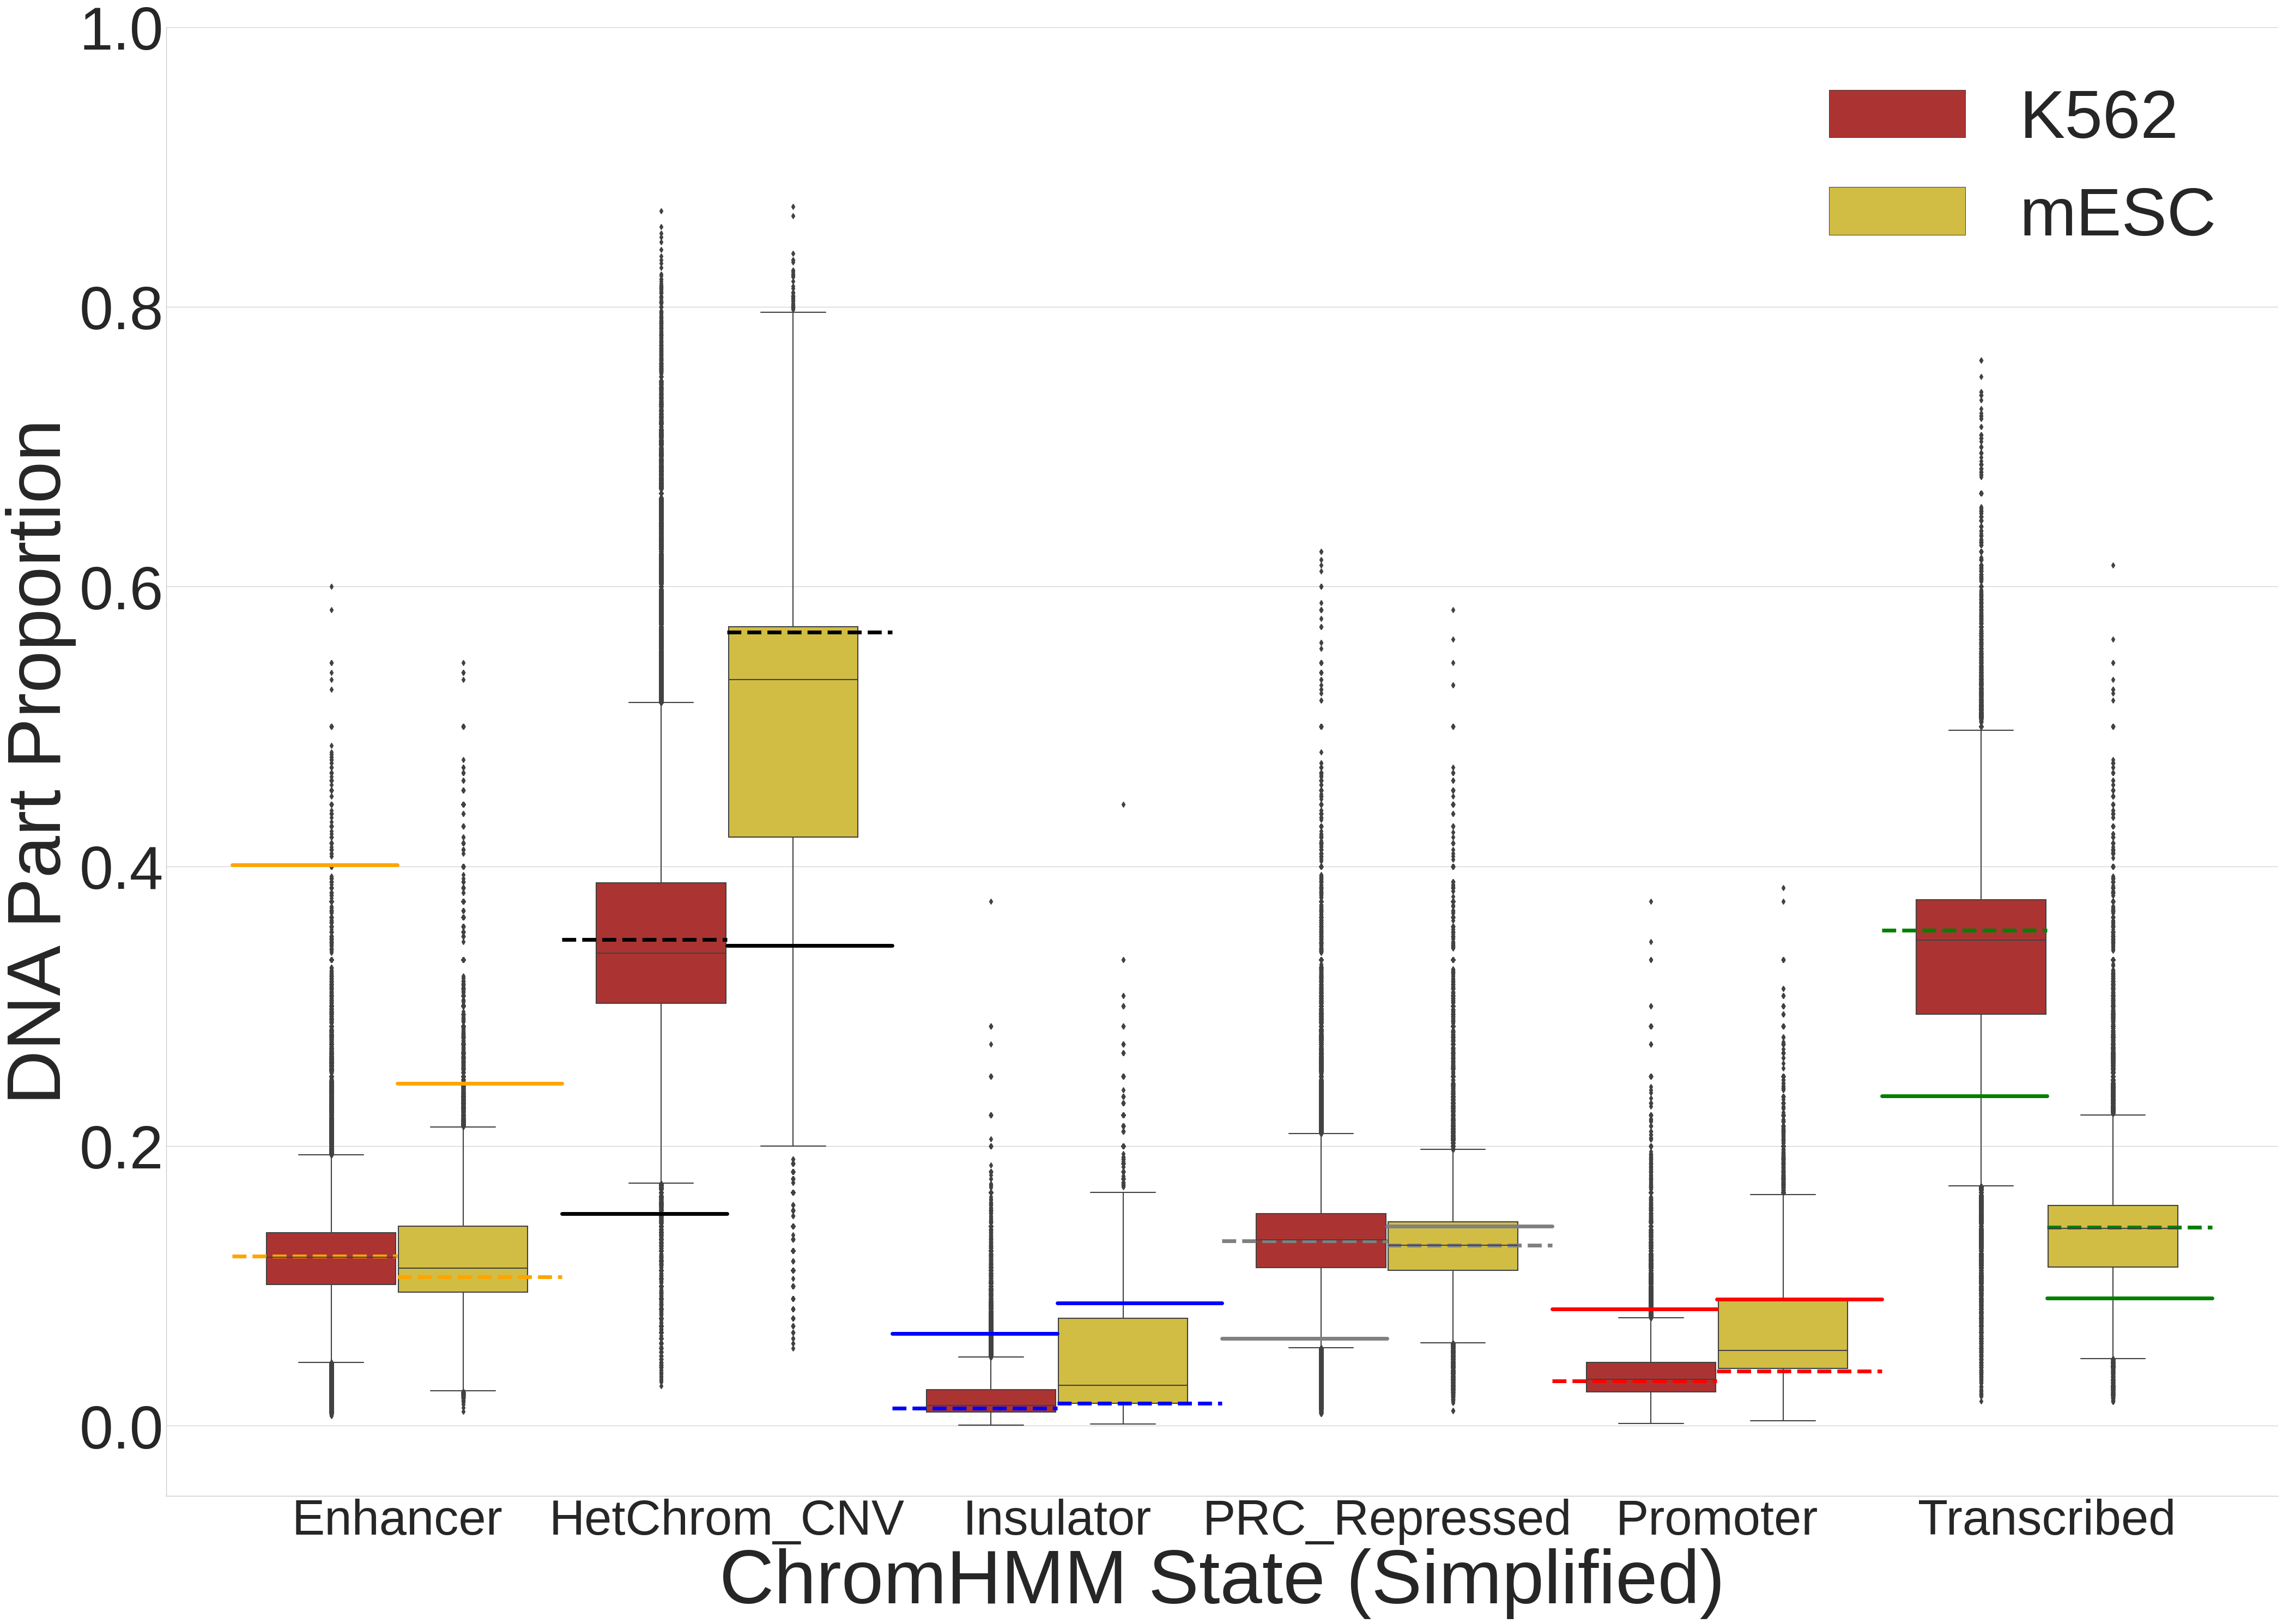

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


plt.figure(figsize=(50, 35))
plt.style.use("seaborn-v0_8-whitegrid")
plt.ylim([-0.05, 1])
plt.tick_params(axis='both', which='major', labelsize= 40)
plt.rc('legend',fontsize=36, title_fontsize=38) 
palette=sns.color_palette(["#BF211E", "#E9CE2C"])

ax = sns.boxplot(data=df, x="variable", y="value", hue="Org", palette=palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
vals = [[0.400871, 0.244877], [0.151647, 0.343363], [0.066022, # real data
             0.087588], [0.062507, 0.142661], [0.083331, 0.090405], 
             [0.235621, 0.091107]]
states = ["Enhancer", "HetChrom_CNV", "Insulator", 
          "PRC_Repressed", "Promoter", "Transcribed"]

vals2 = [[0.121384, 0.106370], [0.347599, 0.567556], [0.012674, # simulated means
         0.016002], [0.132176, 0.129031], [0.031966, 0.038988], 
         [0.354201, 0.142053]]

dt = {k : {"K562": x[0], "mESC":x[1]} for k, x in zip(states, vals)}
dt2 = {k : {"K562": x[0], "mESC":x[1]} for k, x in zip(states, vals2)}

colors = {s : c for s, c in zip(states, ["orange", "black", "blue", "grey", "red", "green"])}

ypos = {c.get_text(): y for c, y in zip(ax.get_xticklabels(), ax.get_xticks())}
print(ypos)
for cat in states:
    for org in ["K562", "mESC"]:
      ax.plot(
          [ypos[cat] - 0.5*(org=="K562"), ypos[cat] + 0.5*(org=="mESC")],
          [dt[cat][org], dt[cat][org]],
          color=colors[cat],
          lw=5,
          )
      ax.plot(
          [ypos[cat] - 0.5*(org=="K562"), ypos[cat] + 0.5*(org=="mESC")],
          [dt2[cat][org], dt2[cat][org]],
          color=colors[cat],
          lw=5, ls="dashed",
          )
ax.tick_params(axis='x', which='major', labelsize = 65)
ax.tick_params(axis='y', which='major', labelsize = 80)
plt.xlabel("ChromHMM State (Simplified)", fontsize = 100)
plt.ylabel("DNA Part Proportion", fontsize = 100)
plt.legend(loc=1, prop={'size': 90})

In [22]:
sim_HMM_df["Org"] = sim_HMM_df["Prot"].apply(lambda x: x.split('.')[1].split('_')[1])
sim_df = sim_HMM_df.iloc[:, [-1,2,3,4,5,6,7]]
k562 = sim_df[sim_df['Org'] == "K562"].set_index("Org")
mesc = sim_df[sim_df['Org'] == "mESC"].set_index("Org")

In [ ]:
k562

In [24]:
mesc.sum(axis=0) / mesc.sum(axis=0).sum()

Enhancer         0.106370
HetChrom_CNV     0.567556
Insulator        0.016002
PRC_Repressed    0.129031
Promoter         0.038988
Transcribed      0.142053
dtype: float64

## Proteins stratified

In [65]:
remodellers = ["CBP", "CBX3", "CHD1", "CHD4", "CHD7", "CTCF", "DNMT1", "EZH2", "HDAC1",
               "HLTF", "LSD1", "MORC2", "PCAF", "PHF8", "RBBP5", "SAFB", "SAFB2", "SUZ12", "WDR5"]
transcribers = ["CHD7", "EWSR1", "FUS", "GTF2F1","HLTF", "HNRNPK", "HNRNPUL1", "LARP7", "PCBP1", 
                "RBM15", "TAF15", "U2AF2", "YBX3", "ZC3H8"]
processors = ["FUS", "HNRNPC","HNRNPH", "HNRNPK", "HNRNPL", "HNRNPUL1", "ILF3", "KHSRP", "LARP7", 
              "NONO", "NUP98", "PTBP1", "RBFOX2", "RBM15", "RBM22", "SRSF1", "SRSF7", "SRSF9", 
              "TARDBP", "U2AF1", "U2AF2", "ZC3H11A"]

In [73]:
tmp_df = df.copy()
tmp_df["Prot"] = tmp_df["Prot"].apply(lambda x: '_'.join(x.split('.')[0::2]))
tmp_df["sign"] = tmp_df["Prot"].apply(lambda x: x.split('_')[0])
tmp_df
remod_df = tmp_df[tmp_df['sign'].isin(remodellers)]
transcr_df = tmp_df[tmp_df['sign'].isin(transcribers)]
transl_df = tmp_df[tmp_df['sign'].isin(processors)]

{'Enhancer': 0, 'HetChrom_CNV': 1, 'Insulator': 2, 'PRC_Repressed': 3, 'Promoter': 4, 'Transcribed': 5}


Text(0.5, 1.0, 'Remodellers triads')

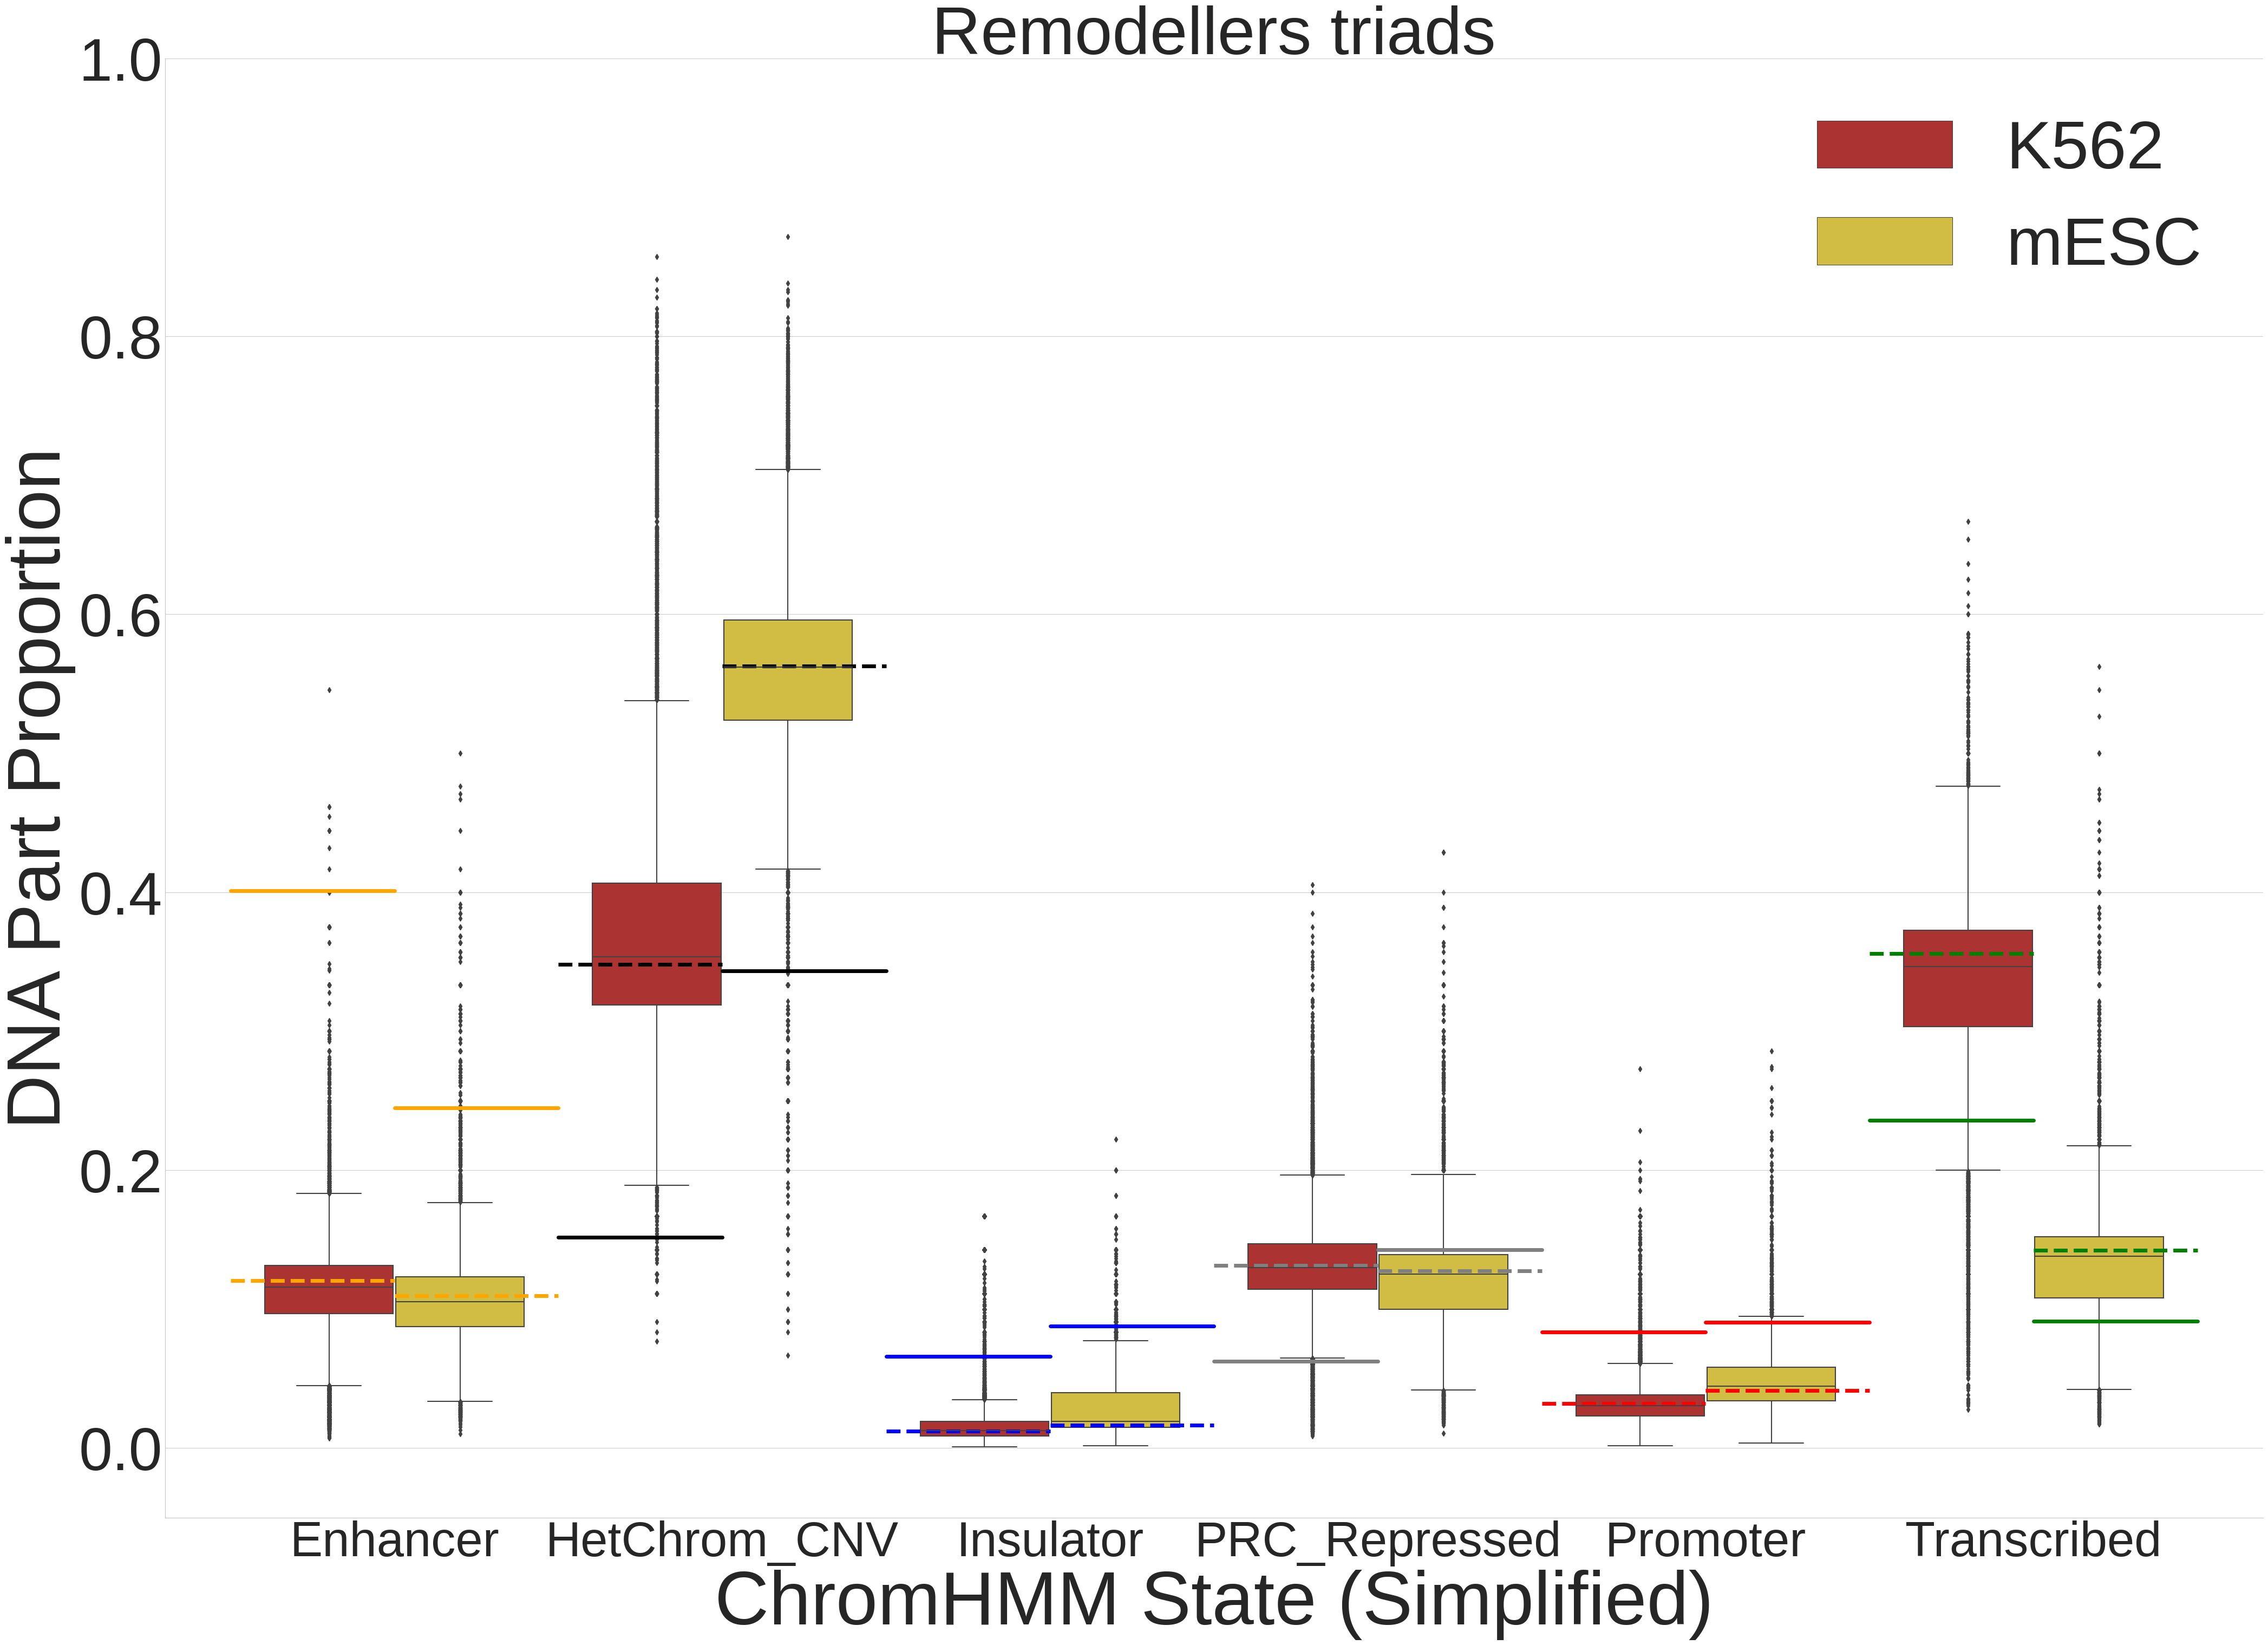

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


plt.figure(figsize=(50, 35))
plt.style.use("seaborn-v0_8-whitegrid")
plt.ylim([-0.05, 1])
plt.tick_params(axis='both', which='major', labelsize= 40)
plt.rc('legend',fontsize=36, title_fontsize=38) 
palette=sns.color_palette(["#BF211E", "#E9CE2C"])

ax = sns.boxplot(data=remod_df, x="variable", y="value", hue="Org", palette=palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
vals = [[0.400871, 0.244877], [0.151647, 0.343363], [0.066022, # real data
             0.087588], [0.062507, 0.142661], [0.083331, 0.090405], 
             [0.235621, 0.091107]]
states = ["Enhancer", "HetChrom_CNV", "Insulator", 
          "PRC_Repressed", "Promoter", "Transcribed"]

vals2 = [[0.120298, 0.109399], [0.348043, 0.562727], [0.012342, # simulated means
         0.016627], [0.131380, 0.127626], [0.031943, 0.041418], 
         [0.355993, 0.142204]]

dt = {k : {"K562": x[0], "mESC":x[1]} for k, x in zip(states, vals)}
dt2 = {k : {"K562": x[0], "mESC":x[1]} for k, x in zip(states, vals2)}

colors = {s : c for s, c in zip(states, ["orange", "black", "blue", "grey", "red", "green"])}

ypos = {c.get_text(): y for c, y in zip(ax.get_xticklabels(), ax.get_xticks())}
print(ypos)
for cat in states:
    for org in ["K562", "mESC"]:
      ax.plot(
          [ypos[cat] - 0.5*(org=="K562"), ypos[cat] + 0.5*(org=="mESC")],
          [dt[cat][org], dt[cat][org]],
          color=colors[cat],
          lw=5,
          )
      ax.plot(
          [ypos[cat] - 0.5*(org=="K562"), ypos[cat] + 0.5*(org=="mESC")],
          [dt2[cat][org], dt2[cat][org]],
          color=colors[cat],
          lw=5, ls="dashed",
          )
ax.tick_params(axis='x', which='major', labelsize = 65)
ax.tick_params(axis='y', which='major', labelsize = 80)
plt.xlabel("ChromHMM State (Simplified)", fontsize = 100)
plt.ylabel("DNA Part Proportion", fontsize = 100)
plt.legend(loc=1, prop={'size': 90})
plt.title("Remodellers triads", fontsize=90)

{'Enhancer': 0, 'HetChrom_CNV': 1, 'Insulator': 2, 'PRC_Repressed': 3, 'Promoter': 4, 'Transcribed': 5}


Text(0.5, 1.0, 'Transcription regulators triads')

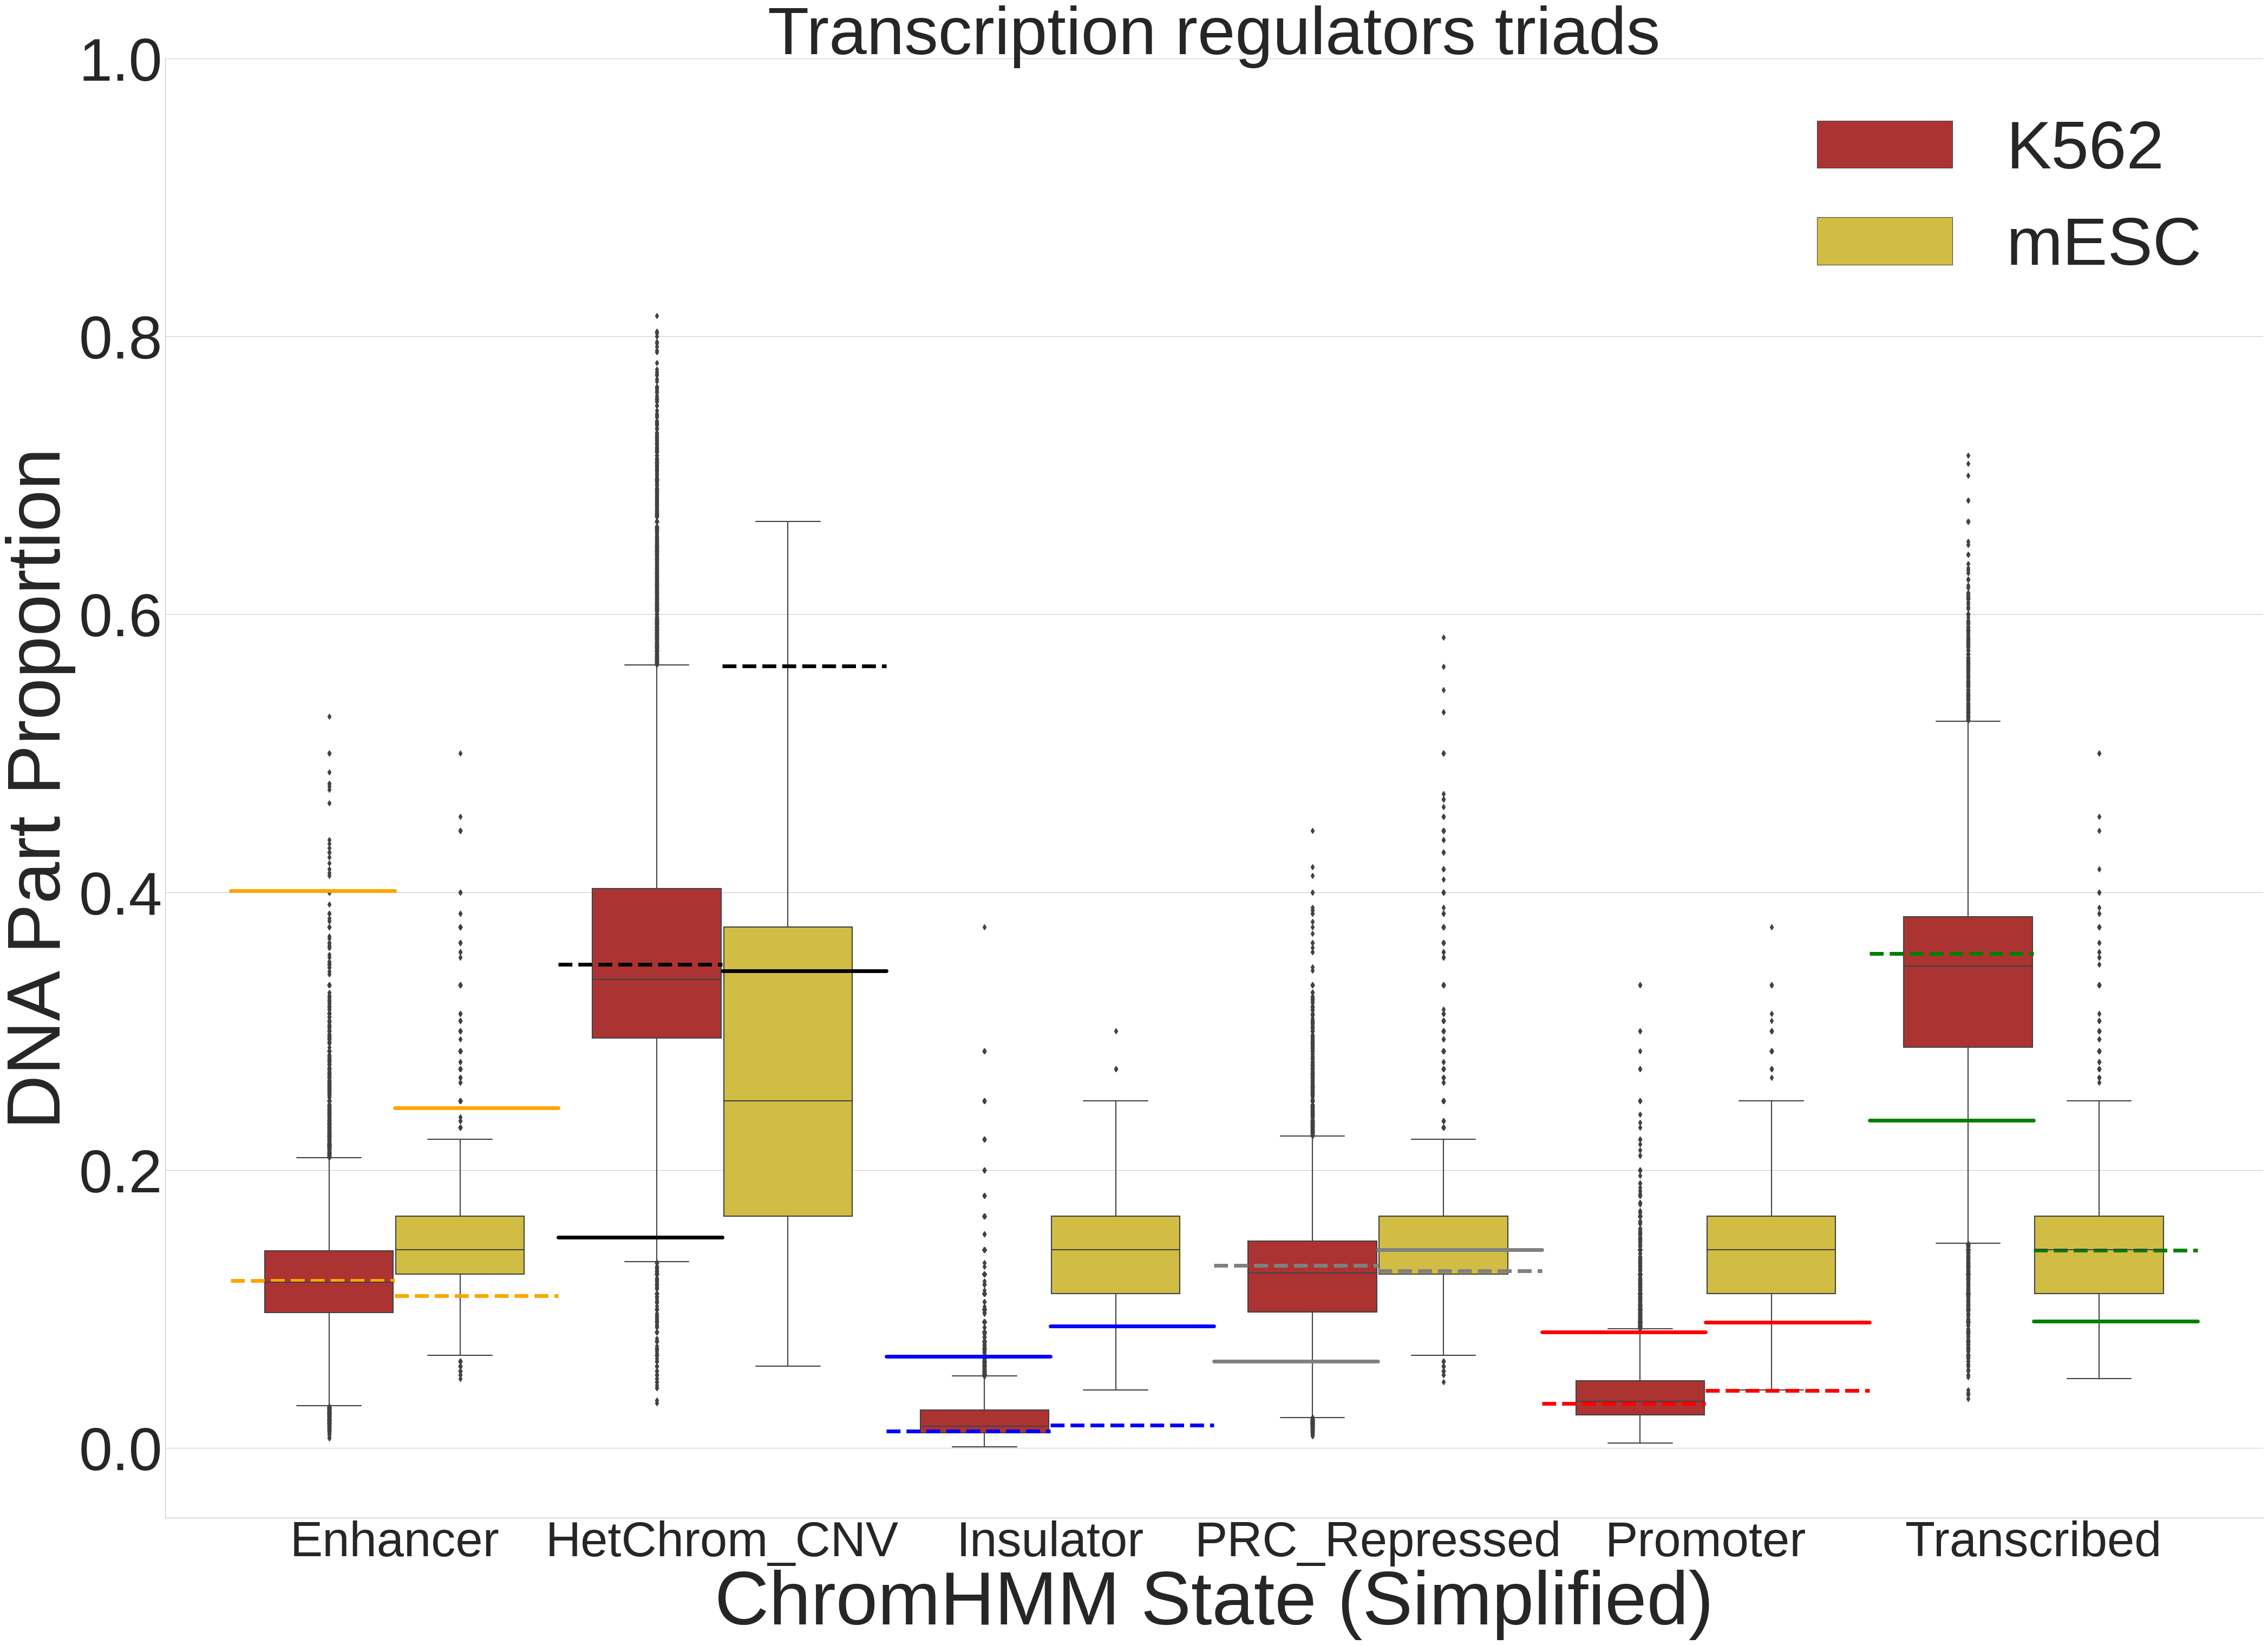

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

df

plt.figure(figsize=(50, 35))
plt.style.use("seaborn-v0_8-whitegrid")
plt.ylim([-0.05, 1])
plt.tick_params(axis='both', which='major', labelsize= 40)
plt.rc('legend',fontsize=36, title_fontsize=38) 
palette=sns.color_palette(["#BF211E", "#E9CE2C"])

ax = sns.boxplot(data=transcr_df, x="variable", y="value", hue="Org", palette=palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
vals = [[0.400871, 0.244877], [0.151647, 0.343363], [0.066022, # real data
             0.087588], [0.062507, 0.142661], [0.083331, 0.090405], 
             [0.235621, 0.091107]]
states = ["Enhancer", "HetChrom_CNV", "Insulator", 
          "PRC_Repressed", "Promoter", "Transcribed"]

vals2 = [[0.120298, 0.109399], [0.348043, 0.562727], [0.012342, # simulated means
         0.016627], [0.131380, 0.127626], [0.031943, 0.041418], 
         [0.355993, 0.142204]]

dt = {k : {"K562": x[0], "mESC":x[1]} for k, x in zip(states, vals)}
dt2 = {k : {"K562": x[0], "mESC":x[1]} for k, x in zip(states, vals2)}

colors = {s : c for s, c in zip(states, ["orange", "black", "blue", "grey", "red", "green"])}

ypos = {c.get_text(): y for c, y in zip(ax.get_xticklabels(), ax.get_xticks())}
print(ypos)
for cat in states:
    for org in ["K562", "mESC"]:
      ax.plot(
          [ypos[cat] - 0.5*(org=="K562"), ypos[cat] + 0.5*(org=="mESC")],
          [dt[cat][org], dt[cat][org]],
          color=colors[cat],
          lw=5,
          )
      ax.plot(
          [ypos[cat] - 0.5*(org=="K562"), ypos[cat] + 0.5*(org=="mESC")],
          [dt2[cat][org], dt2[cat][org]],
          color=colors[cat],
          lw=5, ls="dashed",
          )
ax.tick_params(axis='x', which='major', labelsize = 65)
ax.tick_params(axis='y', which='major', labelsize = 80)
plt.xlabel("ChromHMM State (Simplified)", fontsize = 100)
plt.ylabel("DNA Part Proportion", fontsize = 100)
plt.legend(loc=1, prop={'size': 90})
plt.title("Transcription regulators triads", fontsize=90)

{'Enhancer': 0, 'HetChrom_CNV': 1, 'Insulator': 2, 'PRC_Repressed': 3, 'Promoter': 4, 'Transcribed': 5}


Text(0.5, 1.0, 'Translation and export proteins triads')

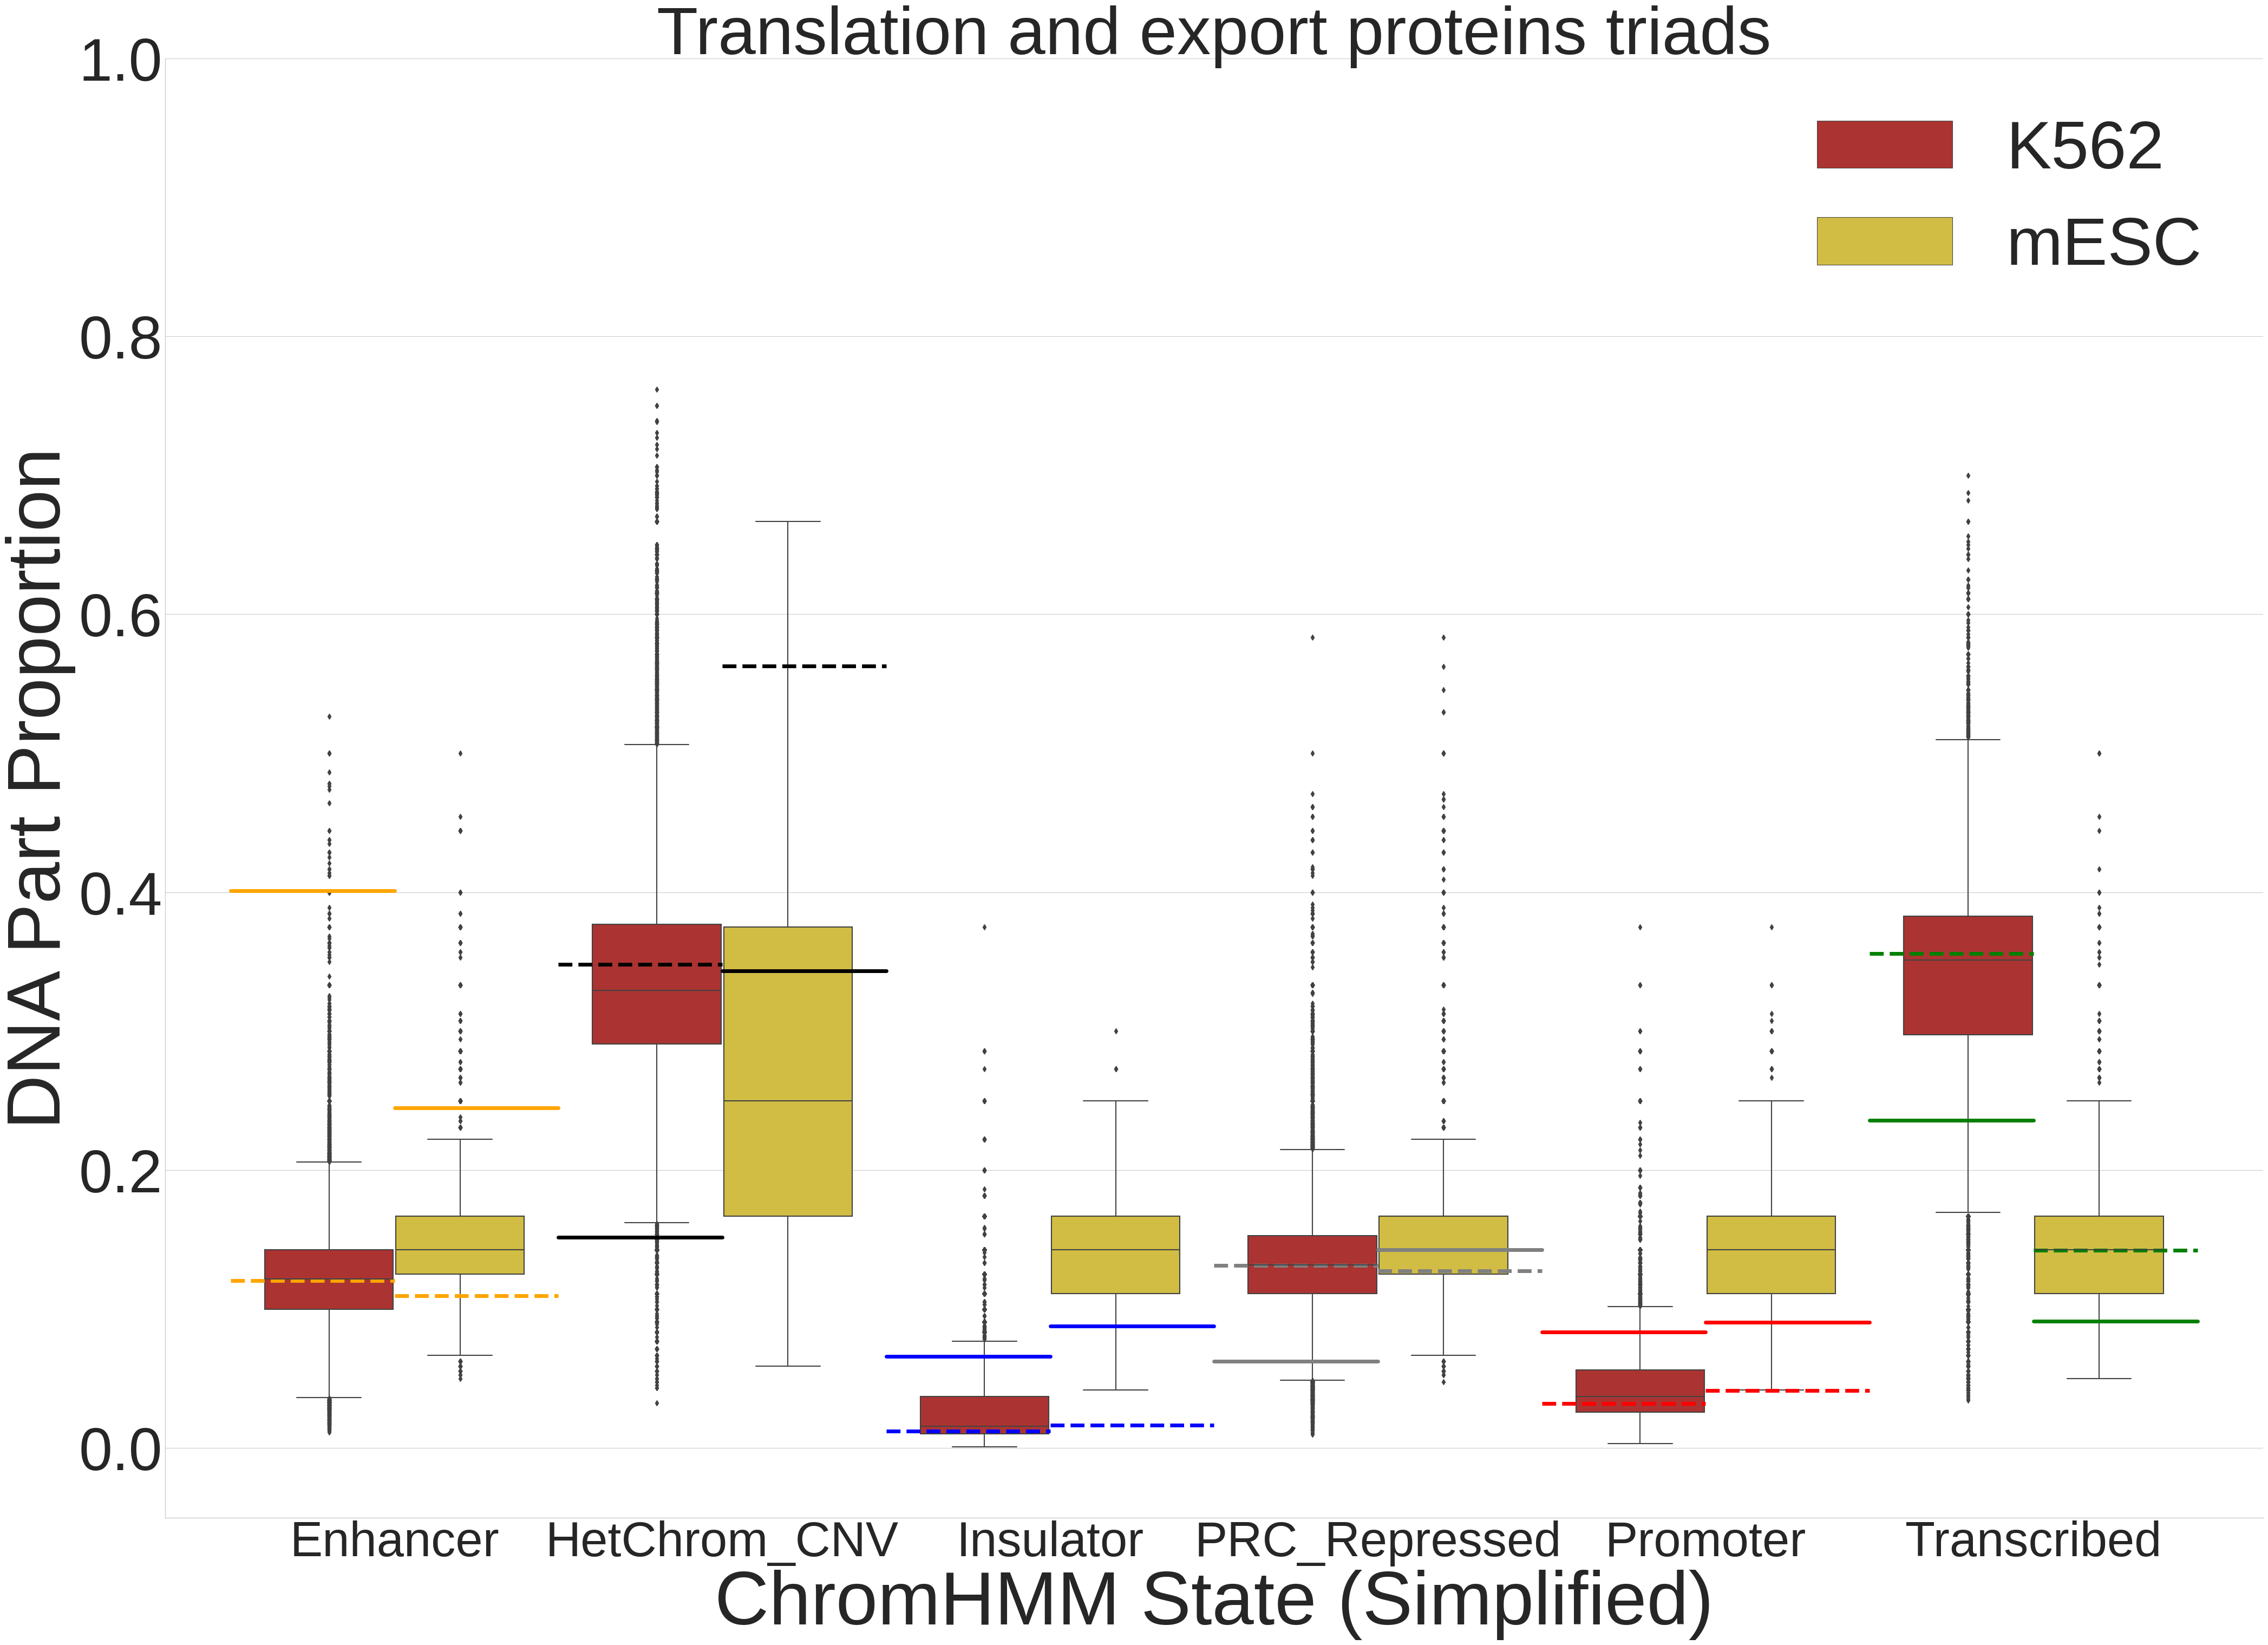

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

df

plt.figure(figsize=(50, 35))
plt.style.use("seaborn-v0_8-whitegrid")
plt.ylim([-0.05, 1])
plt.tick_params(axis='both', which='major', labelsize= 40)
plt.rc('legend',fontsize=36, title_fontsize=38) 
palette=sns.color_palette(["#BF211E", "#E9CE2C"])

ax = sns.boxplot(data=transl_df, x="variable", y="value", hue="Org", palette=palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
vals = [[0.400871, 0.244877], [0.151647, 0.343363], [0.066022, # real data
             0.087588], [0.062507, 0.142661], [0.083331, 0.090405], 
             [0.235621, 0.091107]]
states = ["Enhancer", "HetChrom_CNV", "Insulator", 
          "PRC_Repressed", "Promoter", "Transcribed"]

vals2 = [[0.120298, 0.109399], [0.348043, 0.562727], [0.012342, # simulated means
         0.016627], [0.131380, 0.127626], [0.031943, 0.041418], 
         [0.355993, 0.142204]]

dt = {k : {"K562": x[0], "mESC":x[1]} for k, x in zip(states, vals)}
dt2 = {k : {"K562": x[0], "mESC":x[1]} for k, x in zip(states, vals2)}

colors = {s : c for s, c in zip(states, ["orange", "black", "blue", "grey", "red", "green"])}

ypos = {c.get_text(): y for c, y in zip(ax.get_xticklabels(), ax.get_xticks())}
print(ypos)
for cat in states:
    for org in ["K562", "mESC"]:
      ax.plot(
          [ypos[cat] - 0.5*(org=="K562"), ypos[cat] + 0.5*(org=="mESC")],
          [dt[cat][org], dt[cat][org]],
          color=colors[cat],
          lw=5,
          )
      ax.plot(
          [ypos[cat] - 0.5*(org=="K562"), ypos[cat] + 0.5*(org=="mESC")],
          [dt2[cat][org], dt2[cat][org]],
          color=colors[cat],
          lw=5, ls="dashed",
          )
ax.tick_params(axis='x', which='major', labelsize = 65)
ax.tick_params(axis='y', which='major', labelsize = 80)
plt.xlabel("ChromHMM State (Simplified)", fontsize = 100)
plt.ylabel("DNA Part Proportion", fontsize = 100)
plt.legend(loc=1, prop={'size': 90})
plt.title("Translation and export proteins triads", fontsize=90)

## SPIN results

In [7]:
spin_df = pd.read_table("simres_SPIN.tsv", index_col=0).iloc[:, 1:]
spin_df

,Prot,A_compartment,B_compartment,Lamina,Near_Lm,Speckle,Lamina_Like
0,KHSRP.redc_K562.eCLIP,0.537190,0.132231,0.008264,0.148760,0.165289,0.008264
1,RBFOX2.redc_K562.eCLIP,0.520468,0.091813,0.014620,0.140936,0.221637,0.010526
2,CHD7.redc_K562.fRIP,0.507246,0.057971,0.014493,0.188406,0.217391,0.014493
3,HDAC1.redc_K562.fRIP,0.555975,0.093082,0.017610,0.100629,0.228931,0.003774
4,FUS.redc_K562.eCLIP,0.555556,0.079365,0.063492,0.063492,0.222222,0.015873
...,...,...,...,...,...,...,...
588994,CTCF.redc_K562.fRIP,0.502068,0.105595,0.050512,0.190290,0.141737,0.009798
588995,PTBP1.redc_K562.eCLIP,0.540816,0.051020,0.002551,0.117347,0.283163,0.005102
588997,ZC3H11A.redc_K562.eCLIP,0.550562,0.056180,0.022472,0.044944,0.314607,0.011236
588998,SRSF7.redc_K562.eCLIP,0.437500,0.125000,0.062500,0.062500,0.250000,0.062500


In [8]:
spin_df["Org"] = spin_df["Prot"].apply(lambda x: x.split('.')[1].split('_')[1])
df = spin_df.melt(id_vars=["Prot", "Org"], value_vars=SPIN_states)
df

,Prot,Org,variable,value
0,KHSRP.redc_K562.eCLIP,K562,A_compartment,0.537190
1,RBFOX2.redc_K562.eCLIP,K562,A_compartment,0.520468
2,CHD7.redc_K562.fRIP,K562,A_compartment,0.507246
3,HDAC1.redc_K562.fRIP,K562,A_compartment,0.555975
4,FUS.redc_K562.eCLIP,K562,A_compartment,0.555556
...,...,...,...,...
2782861,CTCF.redc_K562.fRIP,K562,Lamina_Like,0.009798
2782862,PTBP1.redc_K562.eCLIP,K562,Lamina_Like,0.005102
2782863,ZC3H11A.redc_K562.eCLIP,K562,Lamina_Like,0.011236
2782864,SRSF7.redc_K562.eCLIP,K562,Lamina_Like,0.062500


In [18]:
tmp_df = df.loc[:, ["variable", "value"]].set_index("variable")
tmp_df.groupby("variable").mean()

,value
variable,
A_compartment,0.486675
B_compartment,0.107315
Lamina,0.040157
Lamina_Like,0.025404
Near_Lm,0.144633
Speckle,0.195816


{'A_compartment': 0, 'B_compartment': 1, 'Lamina': 2, 'Near_Lm': 3, 'Speckle': 4, 'Lamina_Like': 5}


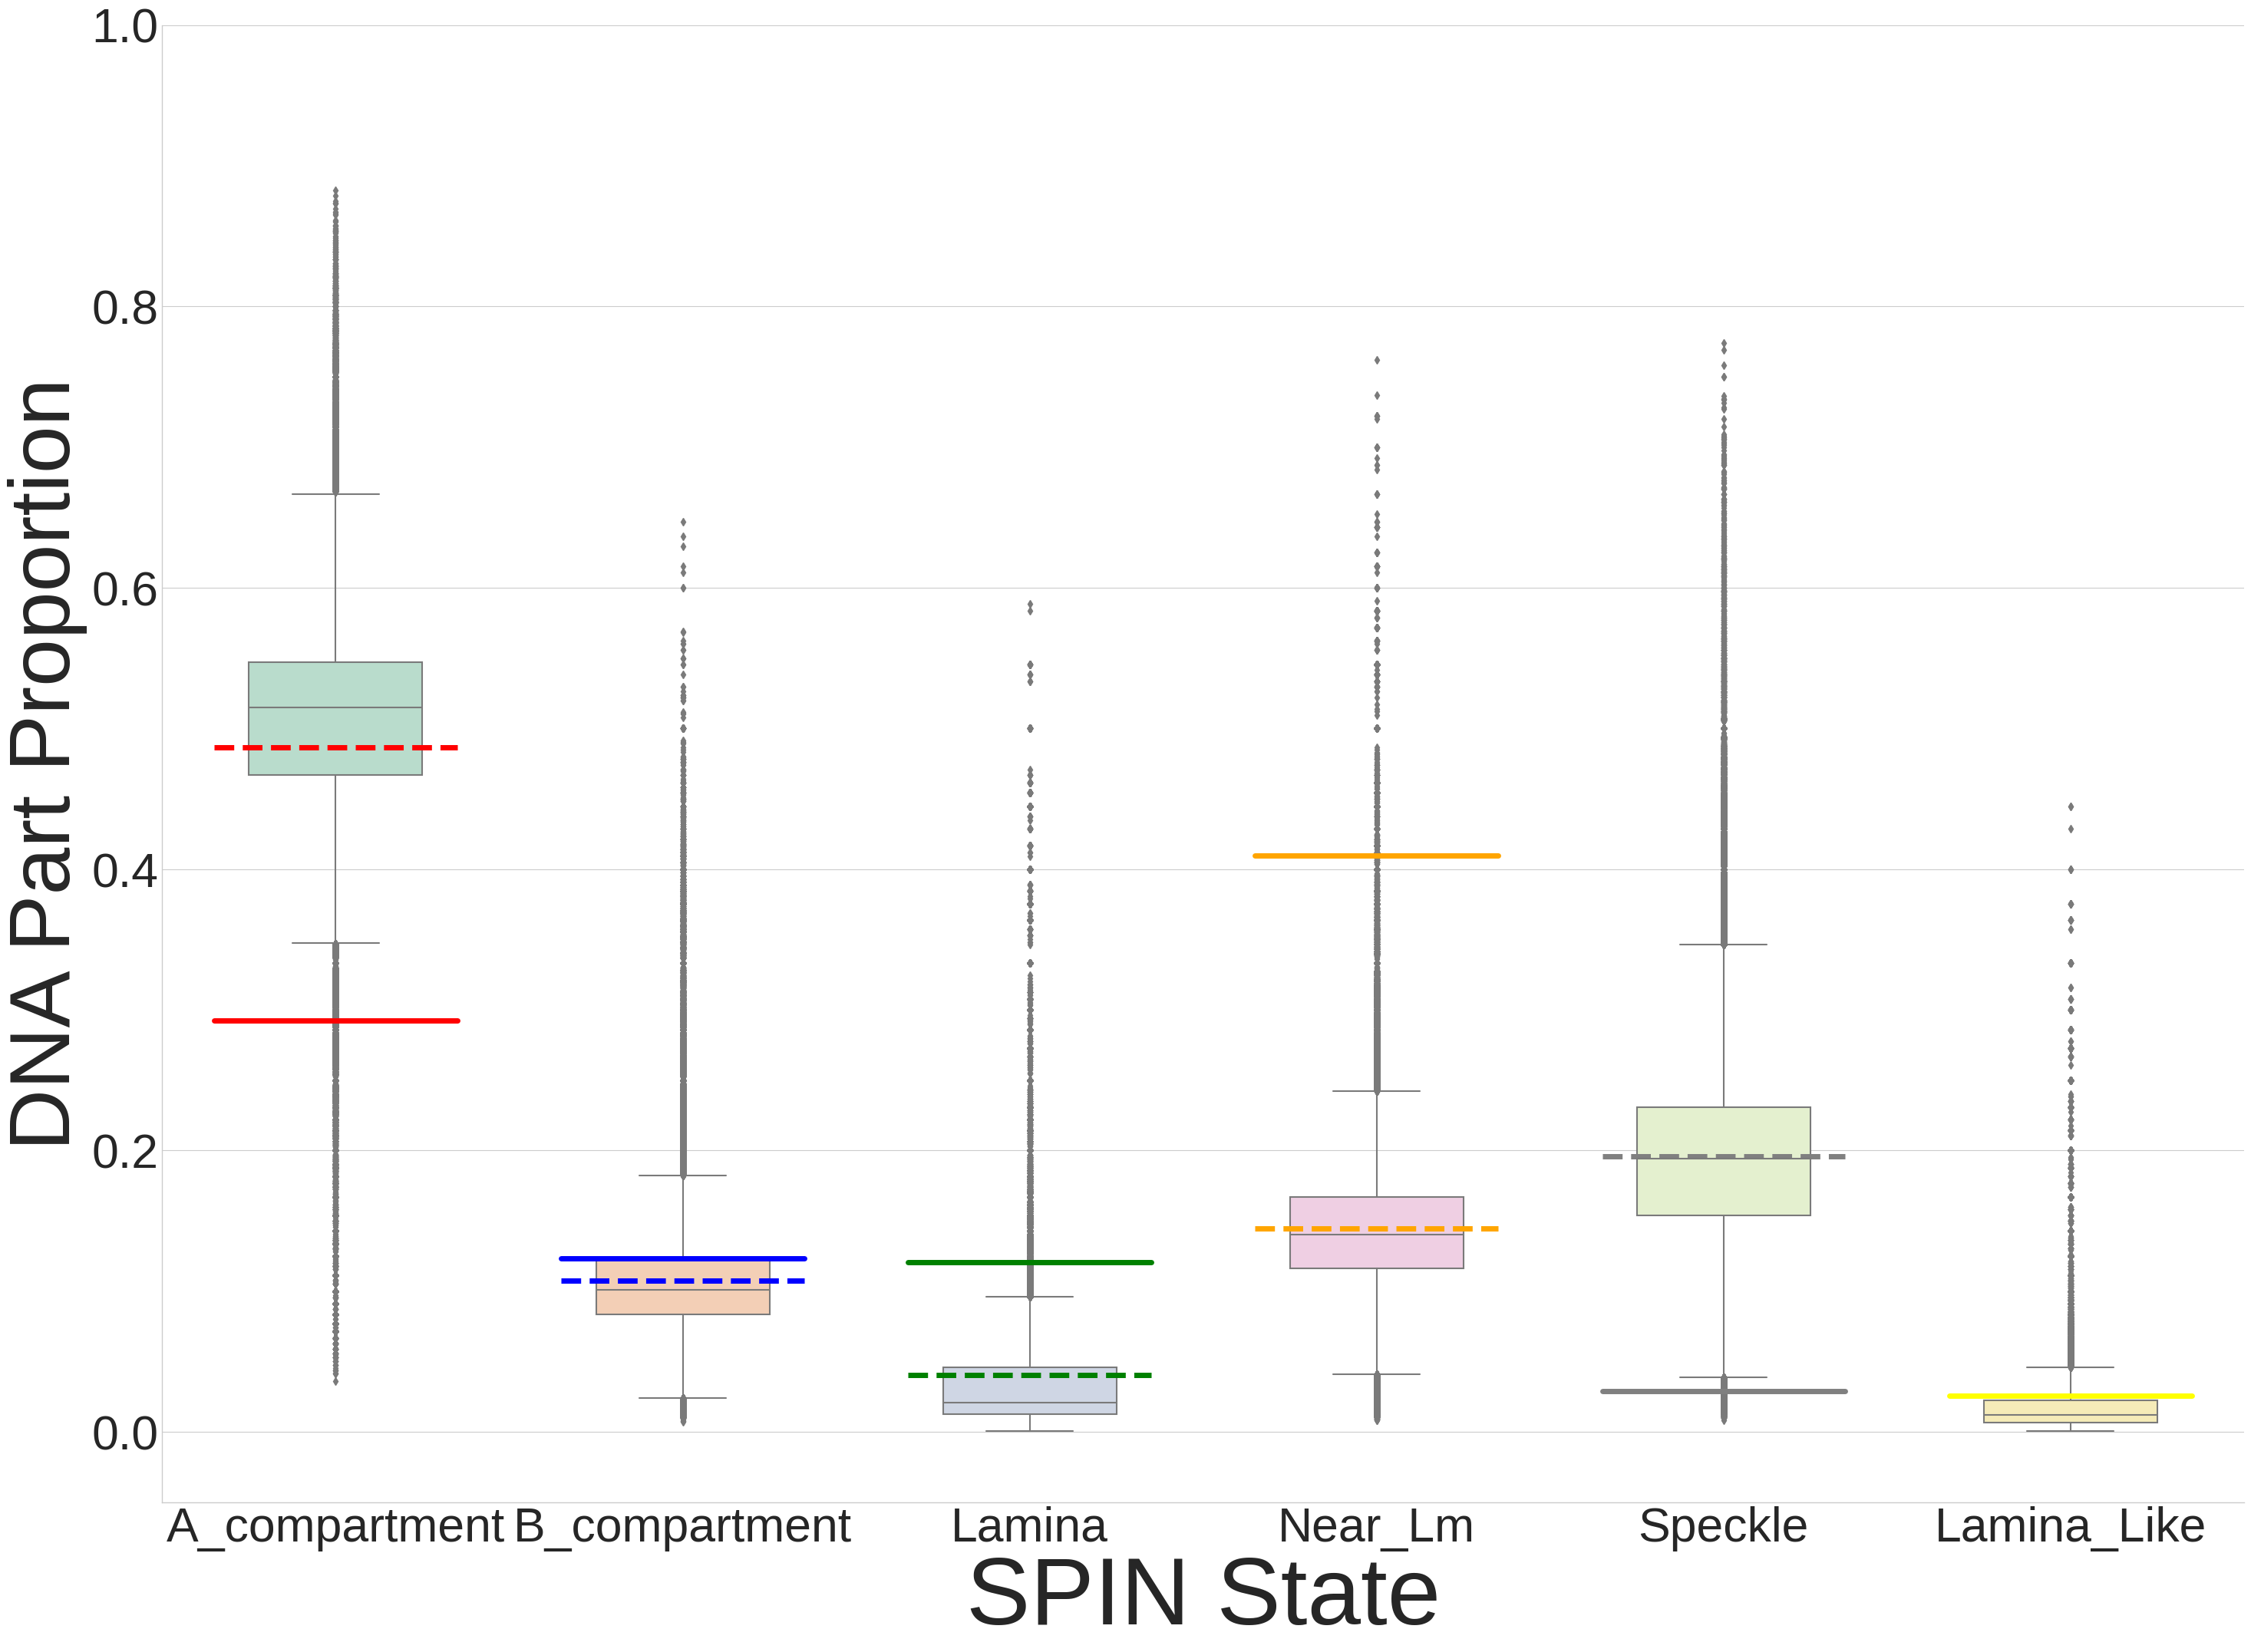

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(35, 25))
plt.style.use("seaborn-v0_8-whitegrid")
plt.ylim([-0.05, 1])
plt.tick_params(axis='both', which='major', labelsize= 45)
plt.rc('legend',fontsize=26, title_fontsize=38) 
palette="Pastel2"

ax = sns.boxplot(data=df, x="variable", y="value", palette=palette, width=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
vals = [0.292239, 0.123060, 0.120621, 0.025499, 0.409534, 0.029047]
states = ['A_compartment', 'B_compartment', 'Lamina',
             'Lamina_Like', 'Near_Lm', 'Speckle']

vals2 = [0.486675, 0.107315, 0.040157, 0.025404, 0.144633, 0.195816]

dt = {k : x for k, x in zip(states, vals)}
dt2 = {k : x for k, x in zip(states, vals2)}

colors = {s : c for s, c in zip(states, ["red", "blue", "green", "yellow", "orange", "gray"])}

ypos = {c.get_text(): y for c, y in zip(ax.get_xticklabels(), ax.get_xticks())}
print(ypos)
for cat in states:
      ax.plot(
          [ypos[cat]-0.35, ypos[cat] + 0.35],
          [dt[cat], dt[cat]],
          color=colors[cat],
          lw=5,
          )
      ax.plot(
          [ypos[cat] - 0.35, ypos[cat] + 0.35],
          [dt2[cat], dt2[cat]],
          color=colors[cat],
          lw=5, ls="dashed",
          )


plt.xlabel("SPIN State", fontsize = 90)
plt.ylabel("DNA Part Proportion", fontsize = 80)
plt.legend([])

In [125]:
tmp_df = df.copy()
tmp_df["Prot"] = tmp_df["Prot"].apply(lambda x: '_'.join(x.split('.')[0::2]))
tmp_df["sign"] = tmp_df["Prot"].apply(lambda x: x.split('_')[0])
tmp_df
remod_df = tmp_df[tmp_df['sign'].isin(remodellers)]
transcr_df = tmp_df[tmp_df['sign'].isin(transcribers)]
transl_df = tmp_df[tmp_df['sign'].isin(processors)]

{'A_compartment': 0, 'B_compartment': 1, 'Lamina': 2, 'Near_Lm': 3, 'Speckle': 4, 'Lamina_Like': 5}


Text(0.5, 1.0, 'Remodellers triads')

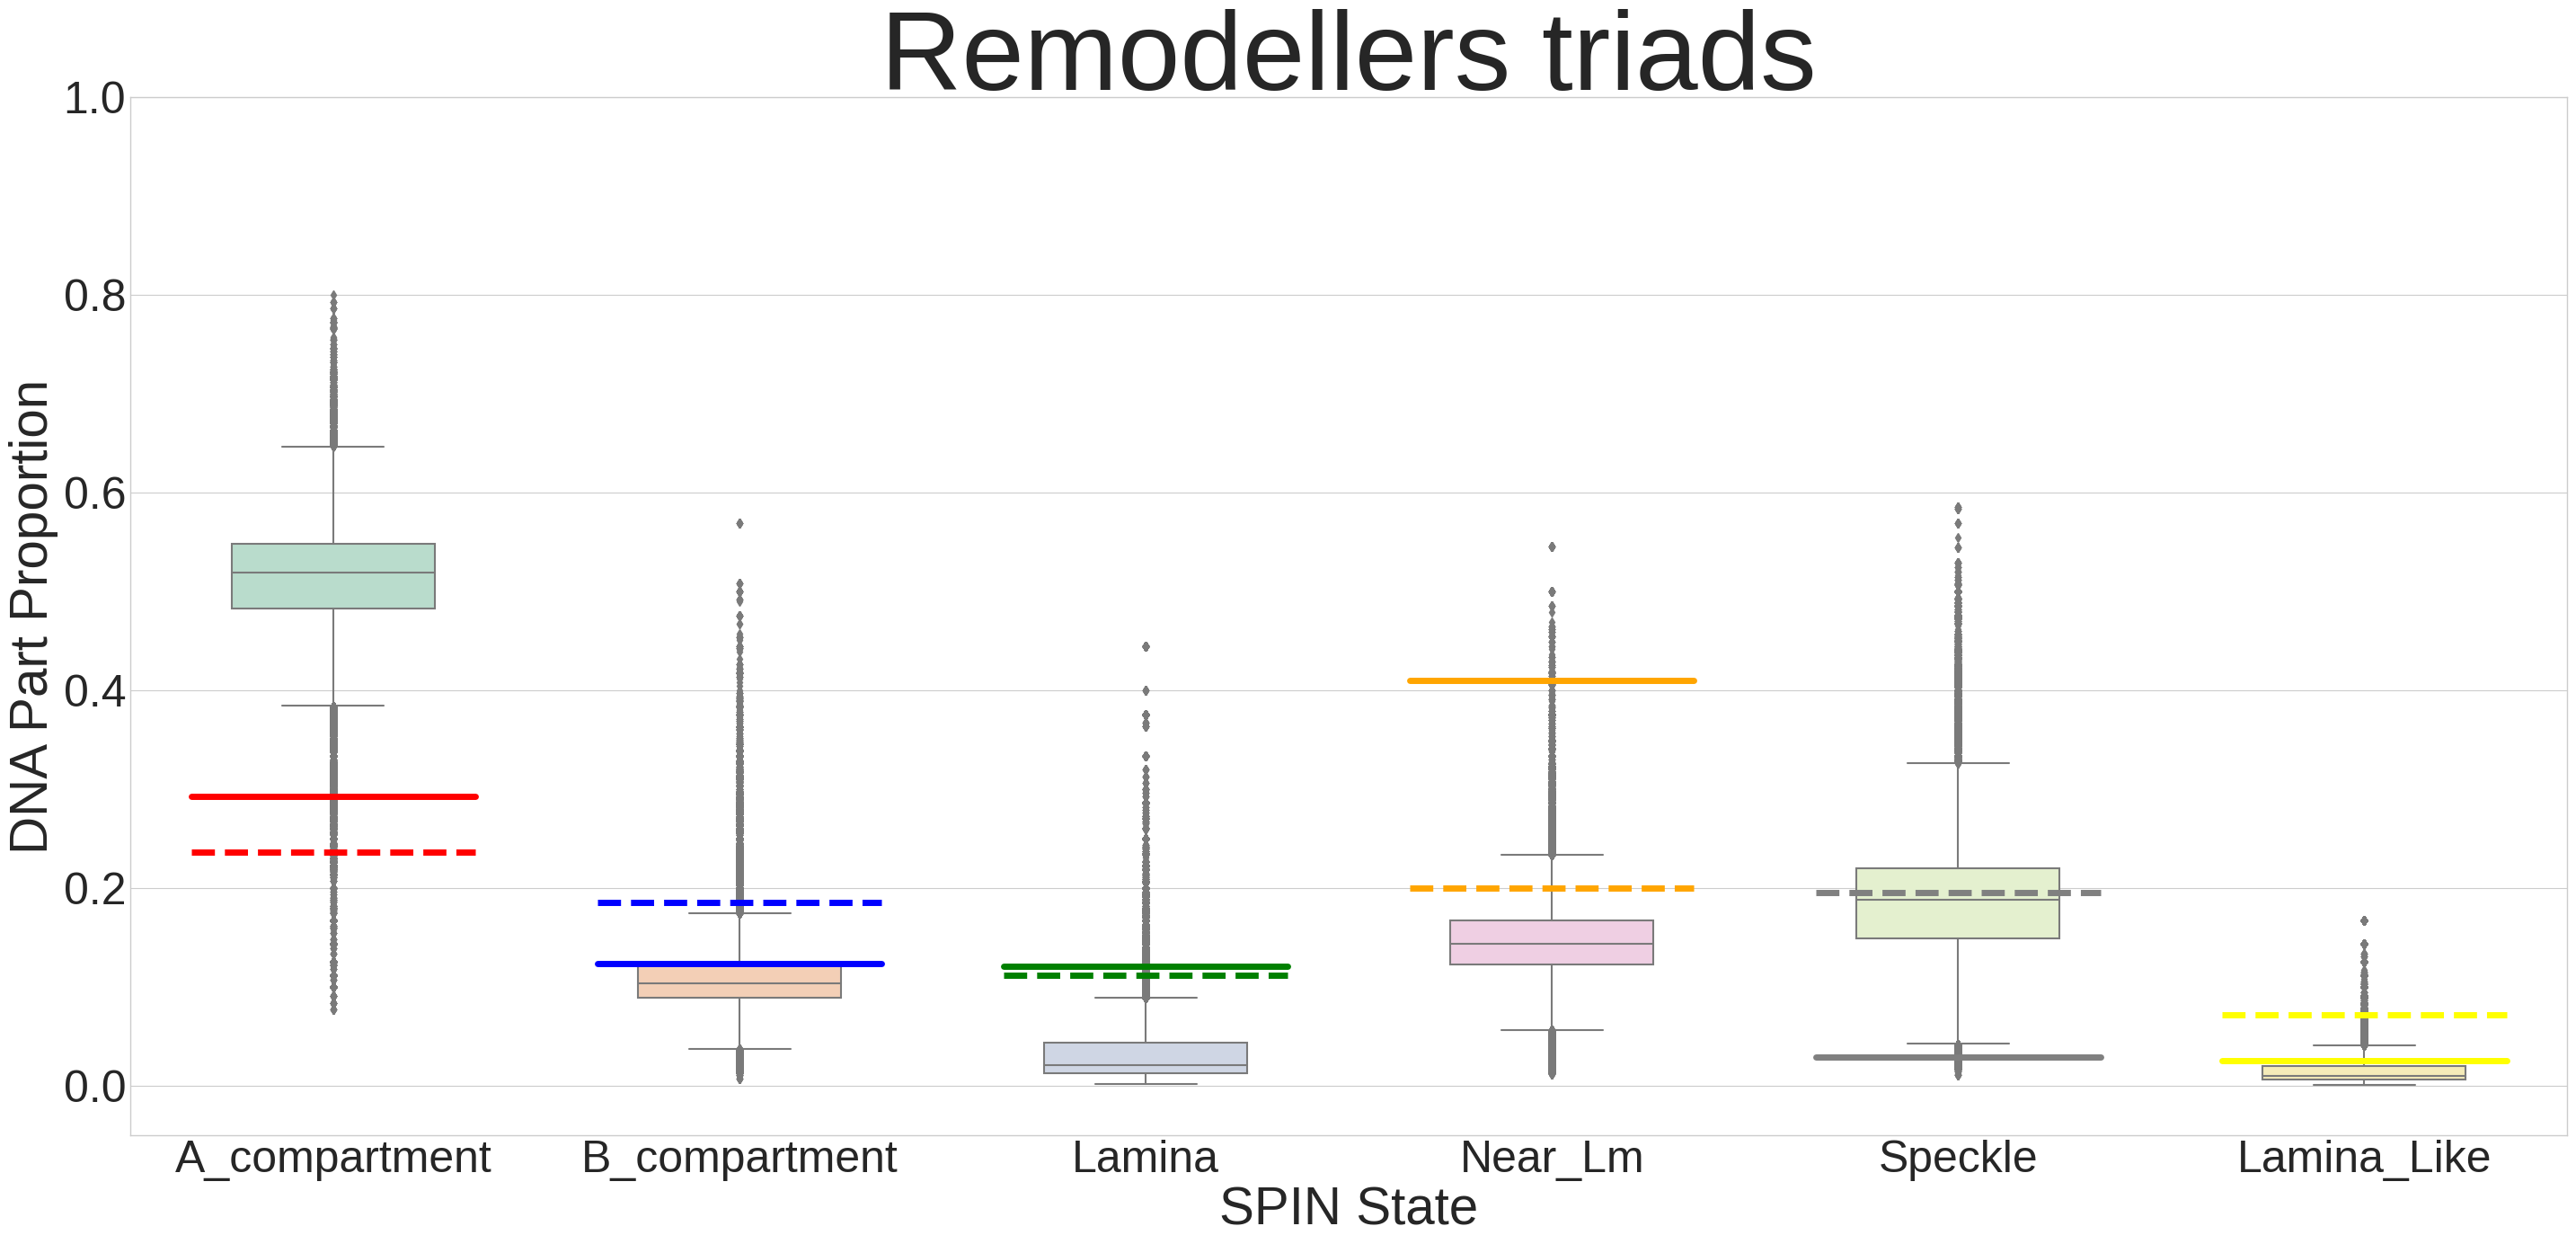

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(35, 15))
plt.style.use("seaborn-v0_8-whitegrid")
plt.ylim([-0.05, 1])
plt.tick_params(axis='both', which='major', labelsize= 36)
plt.rc('legend',fontsize=26, title_fontsize=38) 
palette="Pastel2"

ax = sns.boxplot(data=remod_df, x="variable", y="value", palette=palette, width=0.5)

vals = [0.292239, 0.123060, 0.120621, 0.025499, 0.409534, 0.029047]
states = ['A_compartment', 'B_compartment', 'Lamina',
             'Lamina_Like', 'Near_Lm', 'Speckle']

vals2 = [0.236428, 0.185517, 0.111848, 0.071544, 0.199211, 0.195452]

dt = {k : x for k, x in zip(states, vals)}
dt2 = {k : x for k, x in zip(states, vals2)}

colors = {s : c for s, c in zip(states, ["red", "blue", "green", "yellow", "orange", "gray"])}

ypos = {c.get_text(): y for c, y in zip(ax.get_xticklabels(), ax.get_xticks())}
print(ypos)
for cat in states:
      ax.plot(
          [ypos[cat]-0.35, ypos[cat] + 0.35],
          [dt[cat], dt[cat]],
          color=colors[cat],
          lw=5,
          )
      ax.plot(
          [ypos[cat] - 0.35, ypos[cat] + 0.35],
          [dt2[cat], dt2[cat]],
          color=colors[cat],
          lw=5, ls="dashed",
          )


plt.xlabel("SPIN State", fontsize = 42)
plt.ylabel("DNA Part Proportion", fontsize = 42)
plt.legend([])
plt.title("Remodellers triads", fontsize=90)

{'A_compartment': 0, 'B_compartment': 1, 'Lamina': 2, 'Near_Lm': 3, 'Speckle': 4, 'Lamina_Like': 5}


Text(0.5, 1.0, 'Transciptional regulators triads')

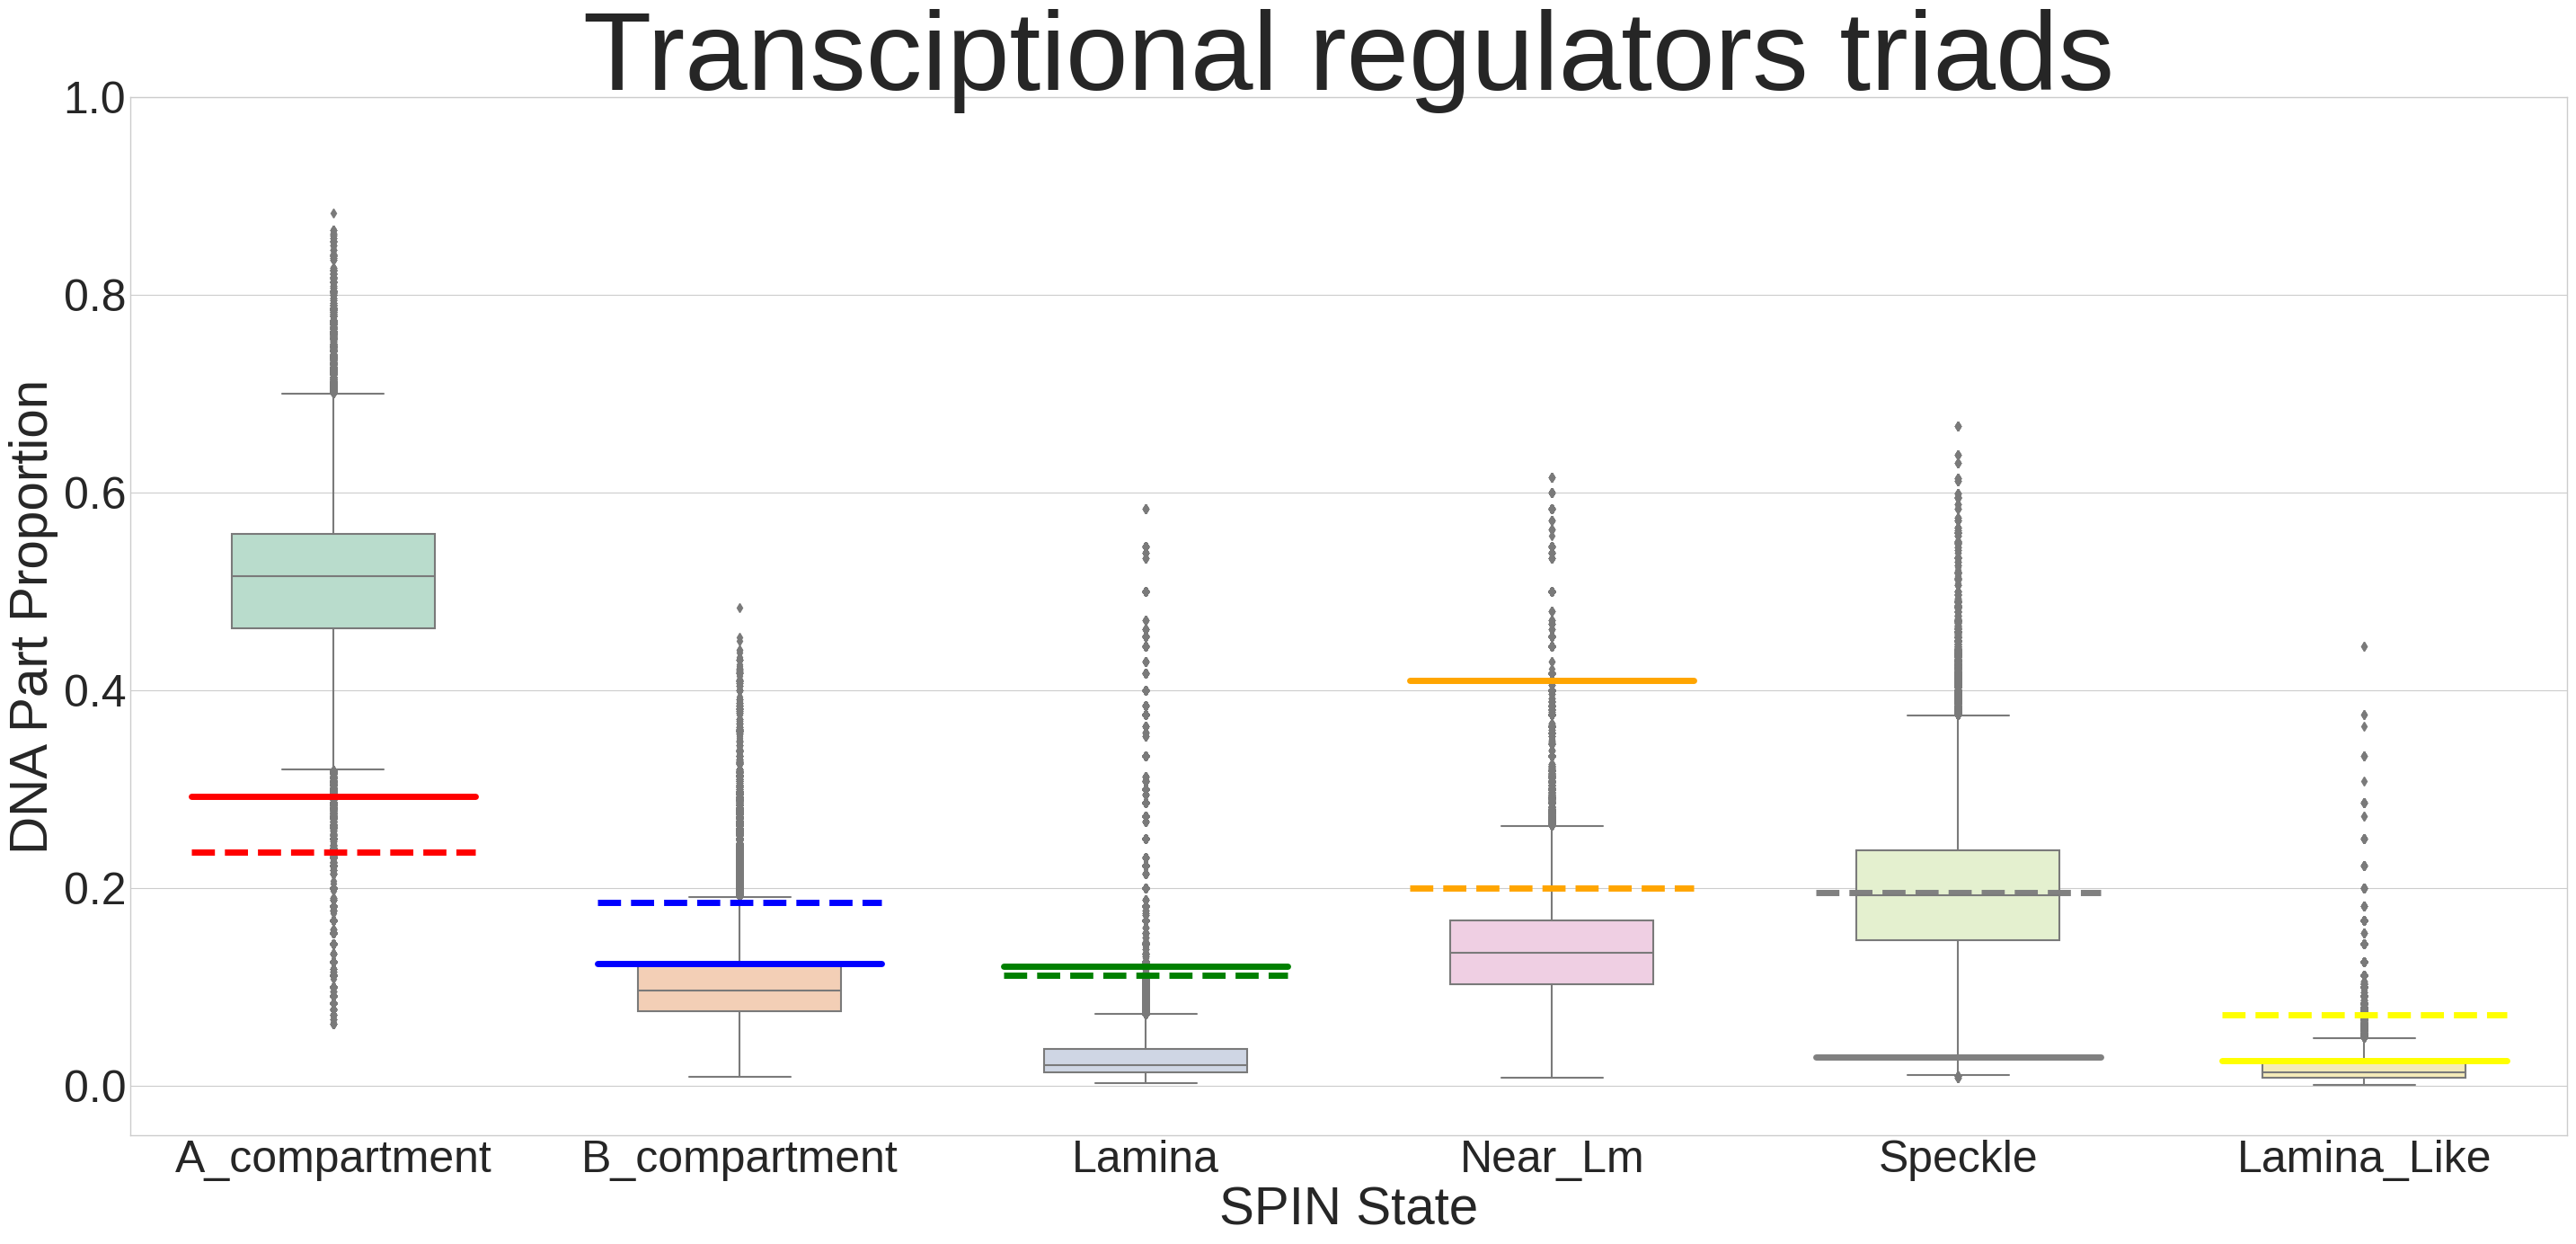

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(35, 15))
plt.style.use("seaborn-v0_8-whitegrid")
plt.ylim([-0.05, 1])
plt.tick_params(axis='both', which='major', labelsize= 36)
plt.rc('legend',fontsize=26, title_fontsize=38) 
palette="Pastel2"

ax = sns.boxplot(data=transcr_df, x="variable", y="value", palette=palette, width=0.5)

vals = [0.292239, 0.123060, 0.120621, 0.025499, 0.409534, 0.029047]
states = ['A_compartment', 'B_compartment', 'Lamina',
             'Lamina_Like', 'Near_Lm', 'Speckle']

vals2 = [0.236428, 0.185517, 0.111848, 0.071544, 0.199211, 0.195452]

dt = {k : x for k, x in zip(states, vals)}
dt2 = {k : x for k, x in zip(states, vals2)}

colors = {s : c for s, c in zip(states, ["red", "blue", "green", "yellow", "orange", "gray"])}

ypos = {c.get_text(): y for c, y in zip(ax.get_xticklabels(), ax.get_xticks())}
print(ypos)
for cat in states:
      ax.plot(
          [ypos[cat]-0.35, ypos[cat] + 0.35],
          [dt[cat], dt[cat]],
          color=colors[cat],
          lw=5,
          )
      ax.plot(
          [ypos[cat] - 0.35, ypos[cat] + 0.35],
          [dt2[cat], dt2[cat]],
          color=colors[cat],
          lw=5, ls="dashed",
          )


plt.xlabel("SPIN State", fontsize = 42)
plt.ylabel("DNA Part Proportion", fontsize = 42)
plt.legend([])
plt.title("Transciptional regulators triads", fontsize=90)

{'A_compartment': 0, 'B_compartment': 1, 'Lamina': 2, 'Near_Lm': 3, 'Speckle': 4, 'Lamina_Like': 5}


Text(0.5, 1.0, 'Translation and export regulators triads')

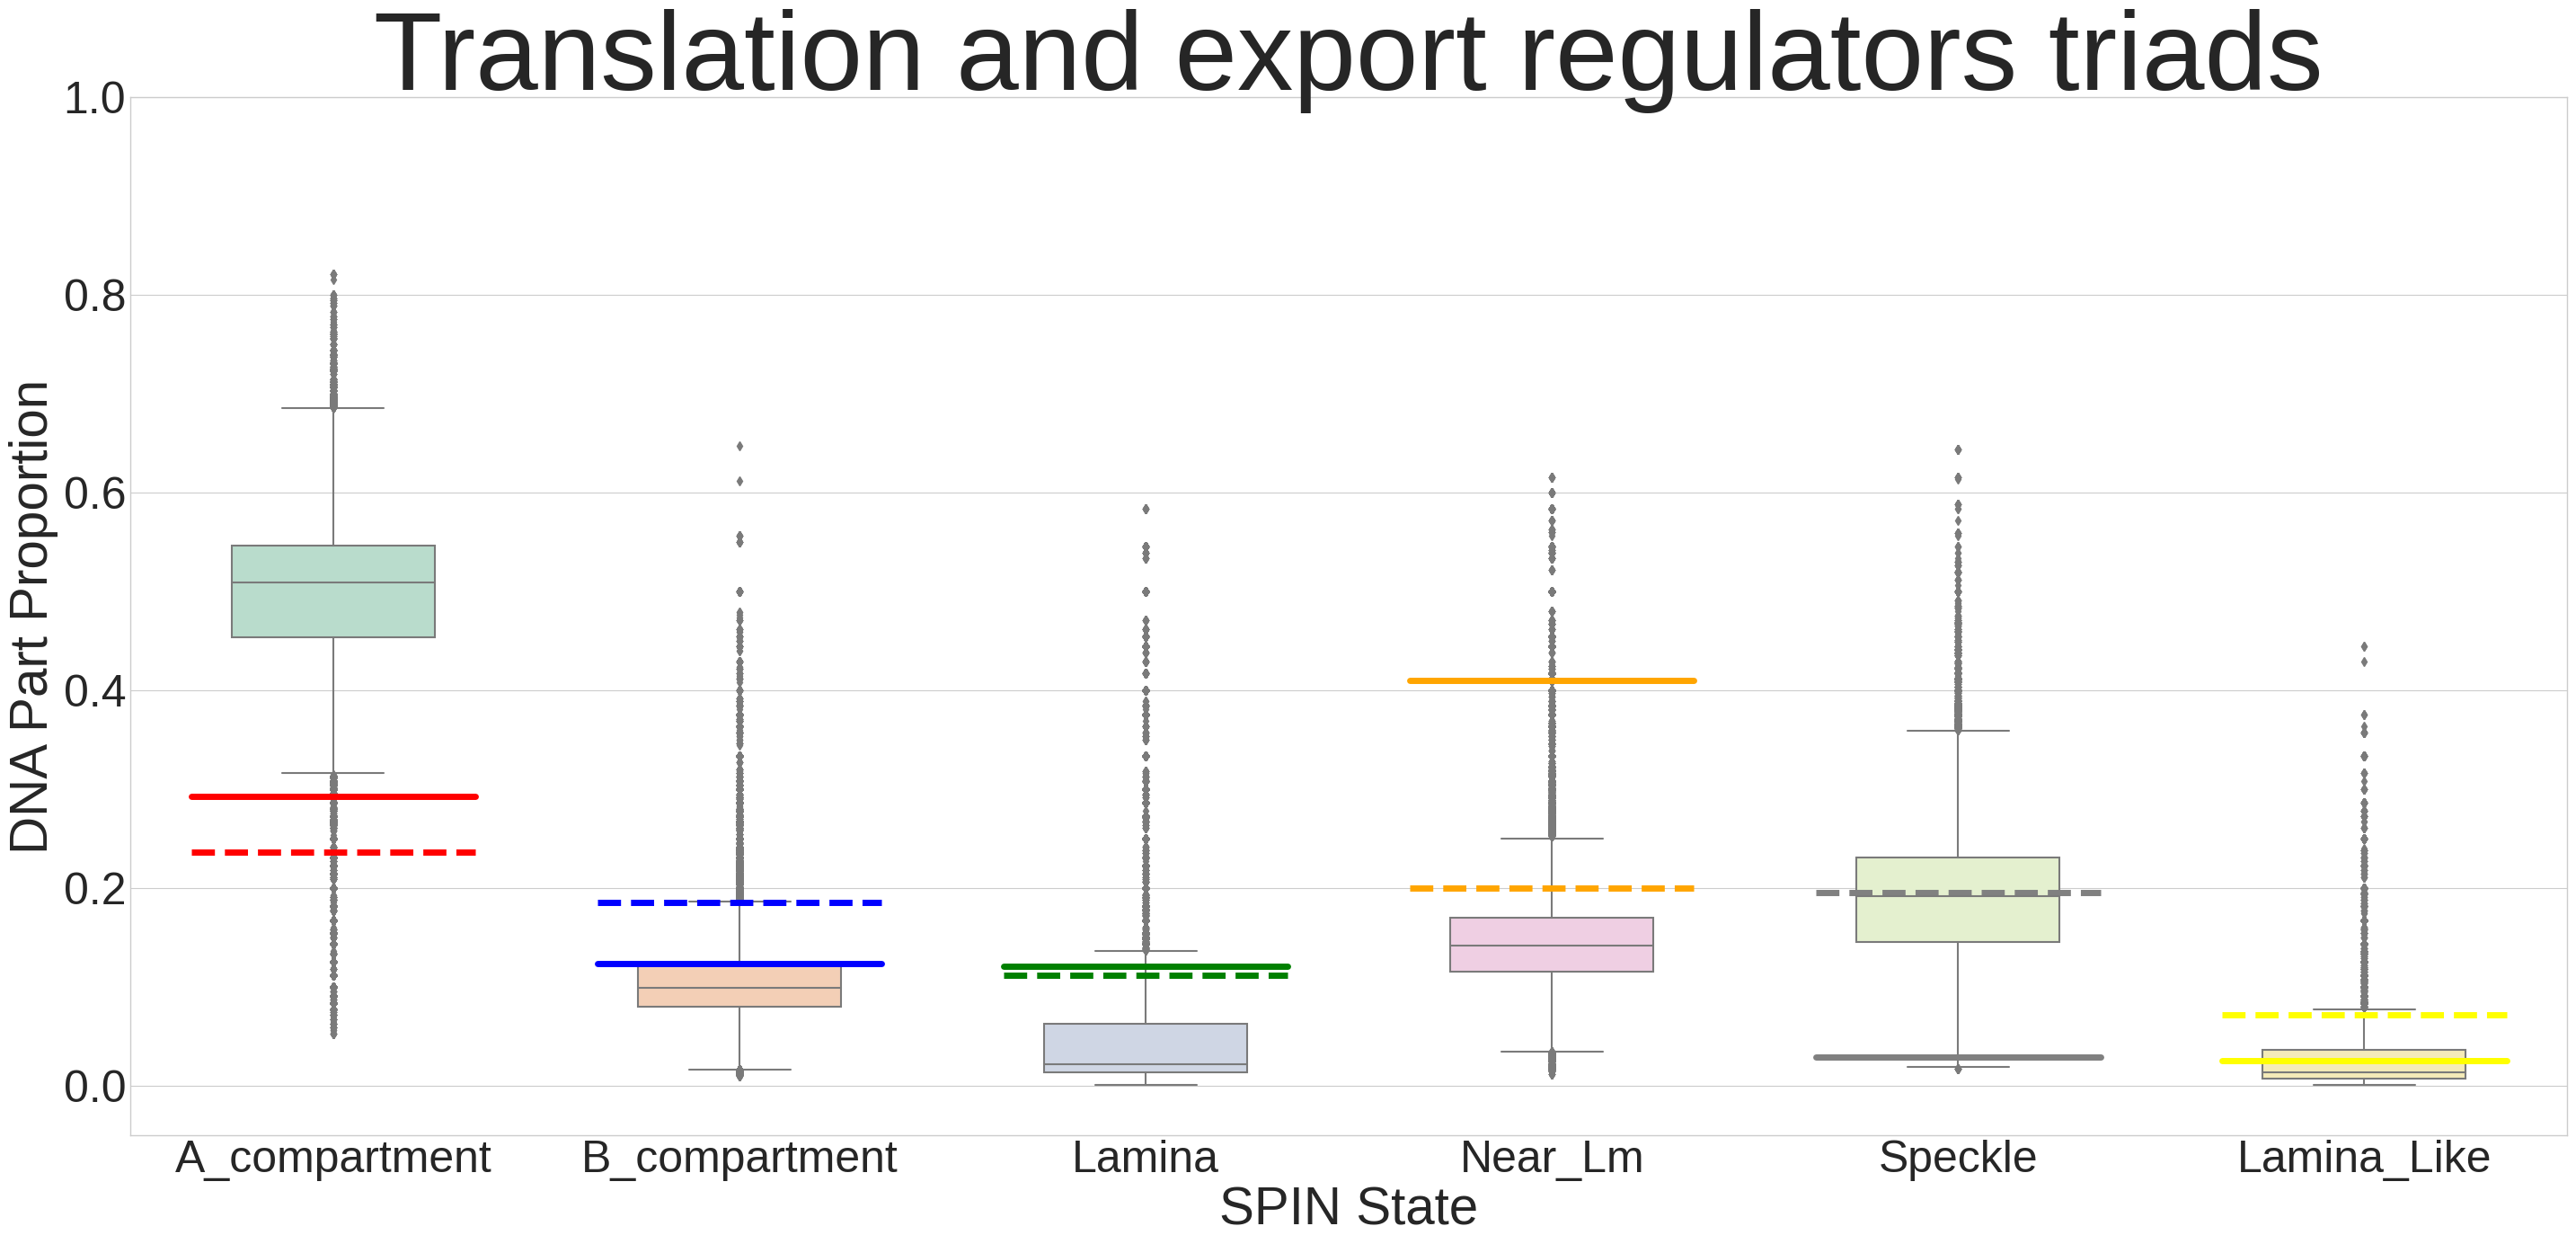

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(35, 15))
plt.style.use("seaborn-v0_8-whitegrid")
plt.ylim([-0.05, 1])
plt.tick_params(axis='both', which='major', labelsize= 36)
plt.rc('legend',fontsize=26, title_fontsize=38) 
palette="Pastel2"

ax = sns.boxplot(data=transl_df, x="variable", y="value", palette=palette, width=0.5)

vals = [0.292239, 0.123060, 0.120621, 0.025499, 0.409534, 0.029047]
states = ['A_compartment', 'B_compartment', 'Lamina',
             'Lamina_Like', 'Near_Lm', 'Speckle']

vals2 = [0.236428, 0.185517, 0.111848, 0.071544, 0.199211, 0.195452]

dt = {k : x for k, x in zip(states, vals)}
dt2 = {k : x for k, x in zip(states, vals2)}

colors = {s : c for s, c in zip(states, ["red", "blue", "green", "yellow", "orange", "gray"])}

ypos = {c.get_text(): y for c, y in zip(ax.get_xticklabels(), ax.get_xticks())}
print(ypos)
for cat in states:
      ax.plot(
          [ypos[cat]-0.35, ypos[cat] + 0.35],
          [dt[cat], dt[cat]],
          color=colors[cat],
          lw=5,
          )
      ax.plot(
          [ypos[cat] - 0.35, ypos[cat] + 0.35],
          [dt2[cat], dt2[cat]],
          color=colors[cat],
          lw=5, ls="dashed",
          )


plt.xlabel("SPIN State", fontsize = 42)
plt.ylabel("DNA Part Proportion", fontsize = 42)
plt.legend([])
plt.title("Translation and export regulators triads", fontsize=90)